## Importing necessary libraries and packages

In [71]:
import torch
import torch.nn as nn
from torch import optim
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from torch.optim import lr_scheduler
import math
import wandb
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import random_split, Dataset
from torch.optim.lr_scheduler import LambdaLR
from sklearn.model_selection import train_test_split

## Making the most of my M2 MacBook Pro

In [72]:
if not torch.backends.mps.is_available():
    if not torch.backends.mps.is_built():
        print("MPS not available because the current PyTorch install was not "
              "built with MPS enabled.")
    else:
        print("MPS not available because the current MacOS version is not 12.3+ "
              "and/or you do not have an MPS-enabled device on this machine.")

else:
    mps_device = torch.device("mps")

device = 'mps' # 'cuda' if torch.cuda.is_available() else 'cpu'

## Getting the path to some relevent folders

In [73]:
checkpoints_path = '/Users/sienkadounia/lab/ai-futures/Project/ewdd/'
label_noise_path = '/Users/sienkadounia/lab/ai-futures/Project/label_noise/'
rlcts_path = '/Users/sienkadounia/lab/checkpoints/rlcts/ewdd/'

## List all hyperparameters in one cell for easy use

In [81]:
lr = 0.1
num_epochs = 2000
data_seed = 42
N = 1000 # Number of samples
D = 5  # Number of features

sigma = 0.5  # Noise
# Set the random seed and test size
RAND_ST = 42
test_size = 0.2
data_seed = 42
epochs = 1000

## Generating the training and testing data

In [82]:
class MyDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        x = self.X[idx]
        y = self.y[idx]
        return x, y

In [83]:
# Let's create the data to train our DLN
# Generate feature matrix X and weight vector w
np.random.seed(data_seed)
X = np.random.randn(N, D)  # Samples from standard normal distribution
X = torch.from_numpy(X).float()

np.random.seed(data_seed)
W_true = np.random.randn(N, D) @ np.random.randn(D, N) # Weights from standard normal distribution
W_true = torch.from_numpy(W_true).float()

'''# Generate noise vector epsilon
np.random.seed(data_seed)
epsilon = sigma * np.random.randn(N)  # Noise from standard normal distribution
epsilon = torch.from_numpy(epsilon)'''

# Compute target variable y
#y = torch.matmul(X, w) + epsilon
y = W_true @ X

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=RAND_ST)

train_dataset = MyDataset(X_train, y_train)
test_dataset = MyDataset(X_test, y_test)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=False)

## Building Deep Linear Network model architecture

In [84]:
# Define the neural network model
class RidgeRegressionNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RidgeRegressionNN, self).__init__()
        self.linear1 = nn.Linear(input_size, hidden_size, bias=False)
        self.linear2 = nn.Linear(hidden_size, output_size, bias=False)

    def forward(self, x):
        x = self.linear1(x)
        x = self.linear2(x)
        return x

In [85]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def lr_lambda(epoch):
    base_lr = 0.1
    return base_lr/math.sqrt(epoch+1)

## Training loop

In [86]:
# Train the model for a range of hidden layer sizes
hidden_layer_sizes = list(range(0, 200, 20))
train_errors = []
test_errors = []
params = []

for hidden_layer_size in hidden_layer_sizes:
    # Update the model architecture
    torch.manual_seed(data_seed)
    input_size = X_train.shape[-1]
    model = RidgeRegressionNN(input_size=input_size,
    hidden_size = input_size + hidden_layer_size,
    output_size=input_size).to(device)
    param = count_parameters(model)
    params.append(param)
    print(f'Number of model parameters is:  {param}')

    criterion = nn.MSELoss()
    # Define the optimizer
    optimizer = optim.SGD(model.parameters(), lr=0.01)
    scheduler = lr_scheduler.LambdaLR(optimizer, lr_lambda)

    wandb.init(project="SLT of Double Descent", 
    config = {'epochs': num_epochs,
              'learning_rate': lr,
              'use_label_noise': 'False',
              'use_test_label_noise': 'False',
              'noise_level': '0',
              'dataset': "Toy Uniform Linear Regression",
              'architecture': "DLN",
              'model_width': count_parameters(model),
              'augmented': 'False',
              'optimizer': 'SGD'})

    wandb.watch(model)
    config = wandb.config

    # Training the model
    step = 0
    for epoch in range(epochs):
        model.train()
        model_train_errors = 0
        for _, data in enumerate(train_loader):
            X_train, y_train = data
            X_train = X_train.to(device)
            y_train = y_train.to(device)
            optimizer.zero_grad()
            y_pred = model(X_train)
            loss = criterion(y_pred.squeeze(), y_train)
            model_train_errors+=loss.item()

            loss.backward()
            optimizer.step()
            
            step += 1
            wandb.log({'batch_loss': loss.item()}, step=step)
        
        model_train_error = model_train_errors / len(train_loader)
        train_errors.append(model_train_error)

        # Computing the training and testing errors
        model.eval()
        model_test_errors = 0
        with torch.no_grad():
            for _, data in enumerate(test_loader):
                X_test, y_test = data
                X_test = X_test.to(device)
                y_test = y_test.to(device)

                y_test_pred = model(X_test)
                test_error = criterion(y_test_pred, y_test)
                model_test_errors+=test_error.item()
                
        model_test_error = model_test_errors / len(test_loader)
        test_errors.append(model_test_error)

        wandb.log({'epoch': epoch,
                    'loss/train': model_train_error,
                    'loss/test': model_test_error,
                }, step=step)

torch.save(model.state_dict(), checkpoints_path + 'dln'+str(hidden_layer_size)+'.pth')

Number of model parameters is:  50


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Number of model parameters is:  250


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Number of model parameters is:  450


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Number of model parameters is:  650


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Number of model parameters is:  850


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Number of model parameters is:  1050


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Number of model parameters is:  1250


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Number of model parameters is:  1450


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Number of model parameters is:  1650


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Number of model parameters is:  1850


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


In [25]:
import pandas as pd
import numpy as np
import seaborn
import matplotlib.pyplot as plt
import einops
from einops import repeat

In [137]:
to_save = list(range(1, 1000, 10))

100

In [82]:
# Ploting the training and testing errors as a function of hidden layer size
dln_metrics = pd.read_csv('/Users/sienkadounia/lab/ai-futures/Project/mwdd/dln.csv')
dim10_metrics = pd.read_csv('/Users/sienkadounia/lab/ai-futures/Project/mwdd/dim10.csv')
dim20_metrics = pd.read_csv('/Users/sienkadounia/lab/ai-futures/Project/mwdd/dim20.csv')
dim40_metrics = pd.read_csv('/Users/sienkadounia/lab/ai-futures/Project/mwdd/dim40.csv')
dim80_metrics = pd.read_csv('/Users/sienkadounia/lab/ai-futures/Project/mwdd/dim80.csv')
dim120_metrics = pd.read_csv('/Users/sienkadounia/lab/ai-futures/Project/mwdd/dim120.csv')

dim10_metrics

epoch  dim10_10 - _step  dim10_10 - _step__MIN  dim10_10 - _step__MAX  \
0        0                 7                      7                      7   
1        1                14                     14                     14   
2        2                21                     21                     21   
3        3                28                     28                     28   
4        4                35                     35                     35   
..     ...               ...                    ...                    ...   
995    995              6972                   6972                   6972   
996    996              6979                   6979                   6979   
997    997              6986                   6986                   6986   
998    998              6993                   6993                   6993   
999    999              7000                   7000                   7000   

     dim10_10 - loss/test  dim10_10 - loss/test__MIN  \
0            1.043920e+04               1.043920e+04   
1            1.021985e+04               1.021985e+04   
2            9.947508e+03               9.947508e+03   
3            9.591767e+03               9.591767e+03   
4            9.102103e+03               9.102103e+03   
..                    ...                        ...   
995          1.009646e-08               1.009646e-08   
996          1.006539e-08               1.006539e-08   
997          9.979834e-09               9.979834e-09   
998          9.924530e-09               9.924530e-09   
999          9.851915e-09               9.851915e-09   

     dim10_10 - loss/test__MAX  dim10_9 - _step  dim10_9 - _step__MIN  \
0                 1.043920e+04                7                     7   
1                 1.021985e+04               14                    14   
2                 9.947508e+03               21                    21   
3                 9.591767e+03               28                    28   
4                 9.102103e+03               35                    35   
..                         ...              ...                   ...   
995               1.009646e-08             6972                  6972   
996               1.006539e-08             6979                  6979   
997               9.979834e-09             6986                  6986   
998               9.924530e-09             6993                  6993   
999               9.851915e-09             7000                  7000   

     dim10_9 - _step__MAX  ...  dim10_2 - _step__MAX  dim10_2 - loss/test  \
0                       7  ...                     7         10582.634277   
1                      14  ...                    14         10530.288574   
2                      21  ...                    21         10462.690918   
3                      28  ...                    28         10368.811035   
4                      35  ...                    35         10225.557129   
..                    ...  ...                   ...                  ...   
995                  6972  ...                  6972             0.000061   
996                  6979  ...                  6979             0.000060   
997                  6986  ...                  6986             0.000060   
998                  6993  ...                  6993             0.000059   
999                  7000  ...                  7000             0.000058   

     dim10_2 - loss/test__MIN  dim10_2 - loss/test__MAX  dim10_1 - _step  \
0                10582.634277              10582.634277                7   
1                10530.288574              10530.288574               14   
2                10462.690918              10462.690918               21   
3                10368.811035              10368.811035               28   
4                10225.557129              10225.557129               35   
..                        ...                       ...              ...   
995                  0.000061                  0.000061      

In [75]:
model_ref = ['dln_50 - loss/test', 'dln_250 - loss/test', 'dln_450 - loss/test', 'dln_650 - loss/test', 'dln_850 - loss/test', 'dln_1050 - loss/test', 'dln_1250 - loss/test', 'dln_1450 - loss/test', 'dln_1650 - loss/test']
model_fig = ['dln_50', 'dln_250', 'dln_450', 'dln_650', 'dln_850', 'dln_1050', 'dln_1250', 'dln_1450', 'dln_1650']

model_losses = []
for i in model_ref:
    model_loss = dln_metrics[i].values
    model_losses.append(model_loss.transpose())

In [151]:
model_ref = ['dln_50 - loss/test', 'dln_250 - loss/test', 'dln_450 - loss/test', 'dln_650 - loss/test', 'dln_850 - loss/test', 'dln_1050 - loss/test', 'dln_1250 - loss/test', 'dln_1450 - loss/test', 'dln_1650 - loss/test']
model_fig = ['dln_50', 'dln_250', 'dln_450', 'dln_650', 'dln_850', 'dln_1050', 'dln_1250', 'dln_1450', 'dln_1650']
num_params = [50, 250, 450, 650, 850, 1050, 1250, 1450, 1650, 1850]
model_losses = []
for i in model_ref:
    model_loss = dln_metrics[i].values[-1]
    model_losses.append(model_loss.transpose())

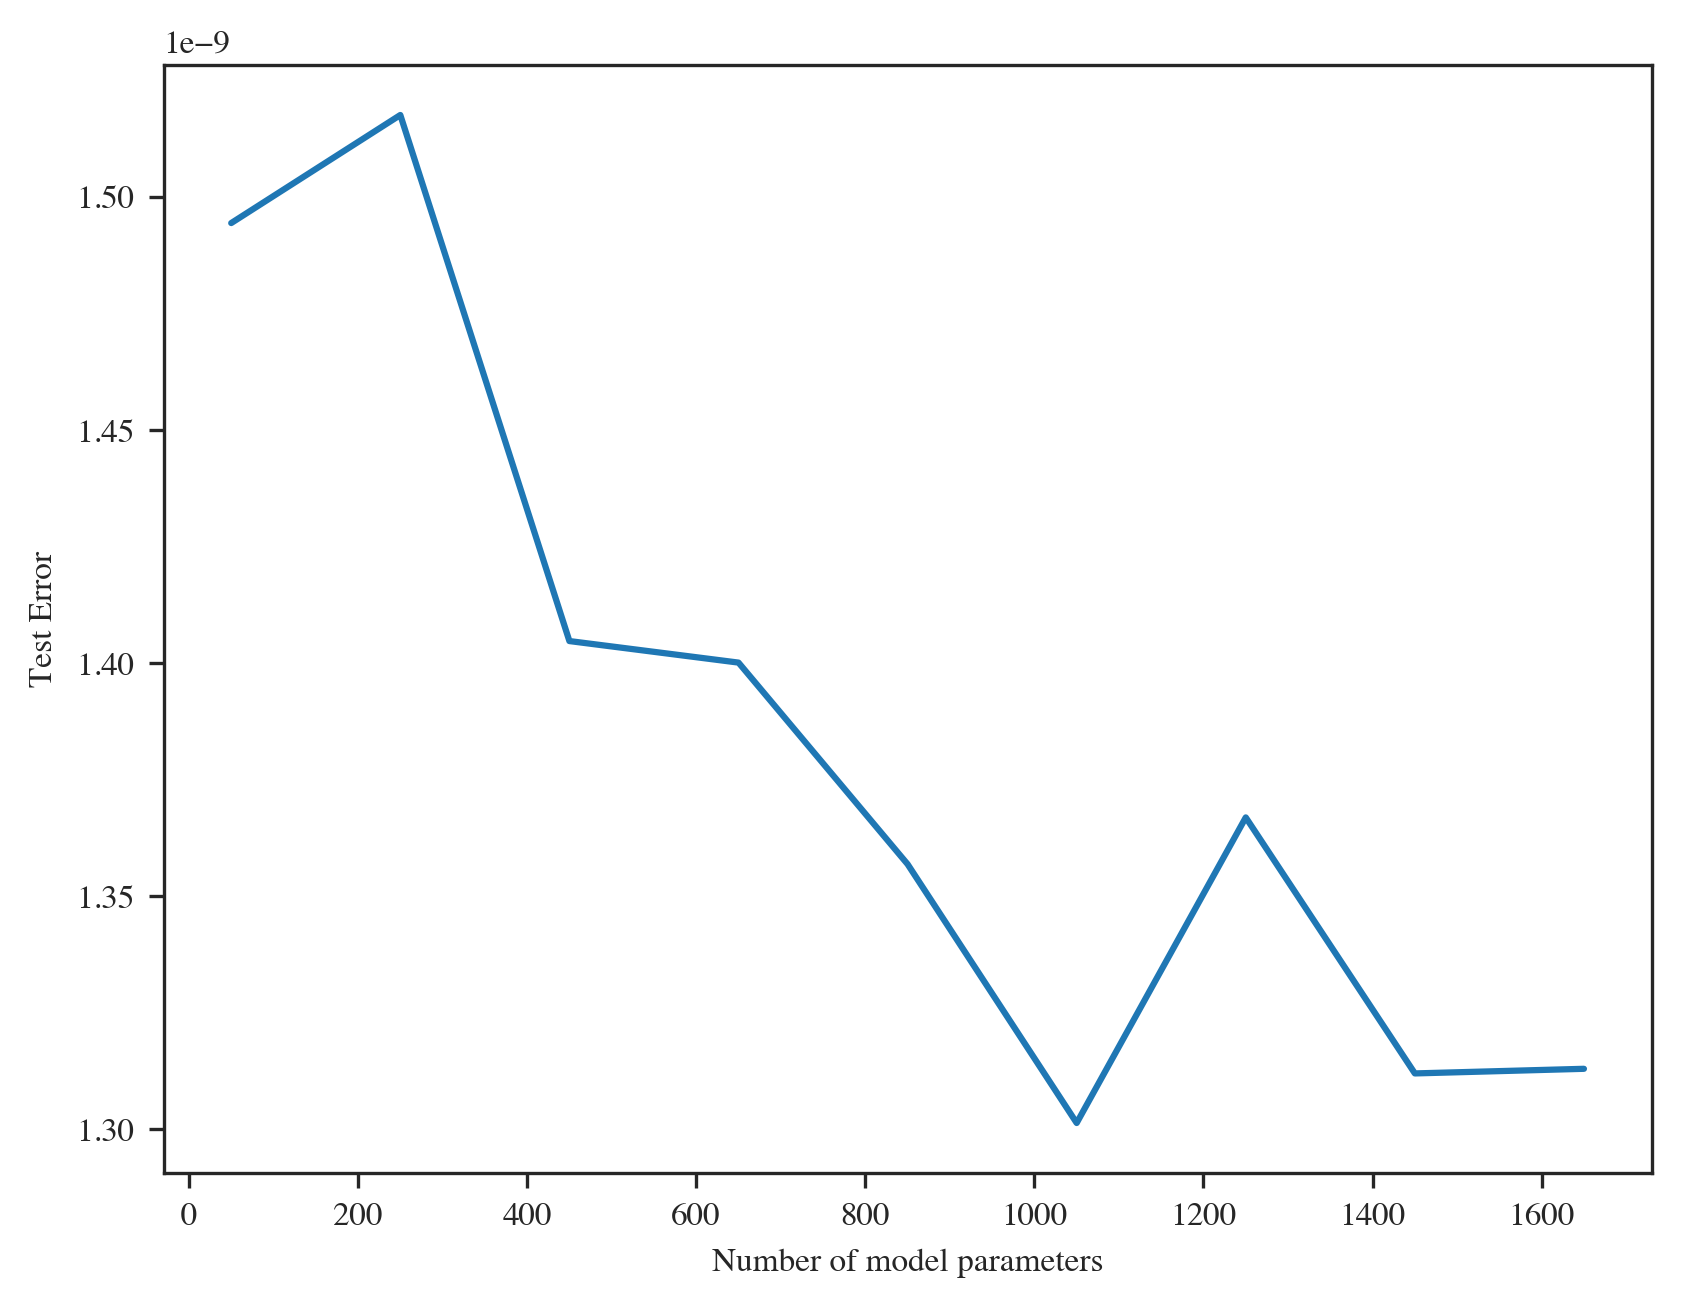

In [158]:
plt.plot(num_params[:9], model_losses)
plt.ylabel('Test Error')
plt.xlabel('Number of model parameters')
#plt.legend(labels = model_fig, loc="upper right")
seaborn.set_style("ticks")
plt.rcParams["font.family"] = "Times"
plt.rcParams['figure.dpi'] = 300
plt.rc('xtick', labelsize=8)
plt.rc('ytick', labelsize=8)
plt.rc('axes', labelsize=8)
#plt.rc('legend', fontsize=8)
plt.rc('axes', titlesize=10)
plt.show()

In [77]:
epoch = list(range(1, 1001))
epochs = repeat(np.array(epoch), 'w -> 10 w')
epochs

array([[   1,    2,    3, ...,  998,  999, 1000],
       [   1,    2,    3, ...,  998,  999, 1000],
       [   1,    2,    3, ...,  998,  999, 1000],
       ...,
       [   1,    2,    3, ...,  998,  999, 1000],
       [   1,    2,    3, ...,  998,  999, 1000],
       [   1,    2,    3, ...,  998,  999, 1000]])

In [78]:
golden_ratio = (5**0.5 - 1) / 2
WIDTH = 3.25
HEIGHT = WIDTH * golden_ratio
some_multiplier_1 = 3
some_multiplier_2 = 3

In [79]:
plt.figure(figsize = (some_multiplier_1 * WIDTH, some_multiplier_2 * HEIGHT))
plt.plot(epoch, model_losses[0])
plt.plot(epoch, model_losses[1])
plt.plot(epoch, model_losses[2])
plt.plot(epoch, model_losses[3])
plt.plot(epoch, model_losses[4])
plt.plot(epoch, model_losses[5])
plt.plot(epoch, model_losses[6])
plt.plot(epoch, model_losses[7])
plt.plot(epoch, model_losses[8])
#plt.plot(epoch, model_losses[9])
plt.xscale('log')
plt.yscale('log')

plt.ylabel('Test Error')
plt.xlabel('Epoch')
plt.legend(labels = model_fig, loc="upper right")
seaborn.set_style("ticks")
plt.rcParams["font.family"] = "Times"
plt.rcParams['figure.dpi'] = 300
plt.rc('xtick', labelsize=8)
plt.rc('ytick', labelsize=8)
plt.rc('axes', labelsize=8)
plt.rc('legend', fontsize=8)
plt.rc('axes', titlesize=10)

#plt.savefig("ten_percent_losses.pdf")
plt.show()

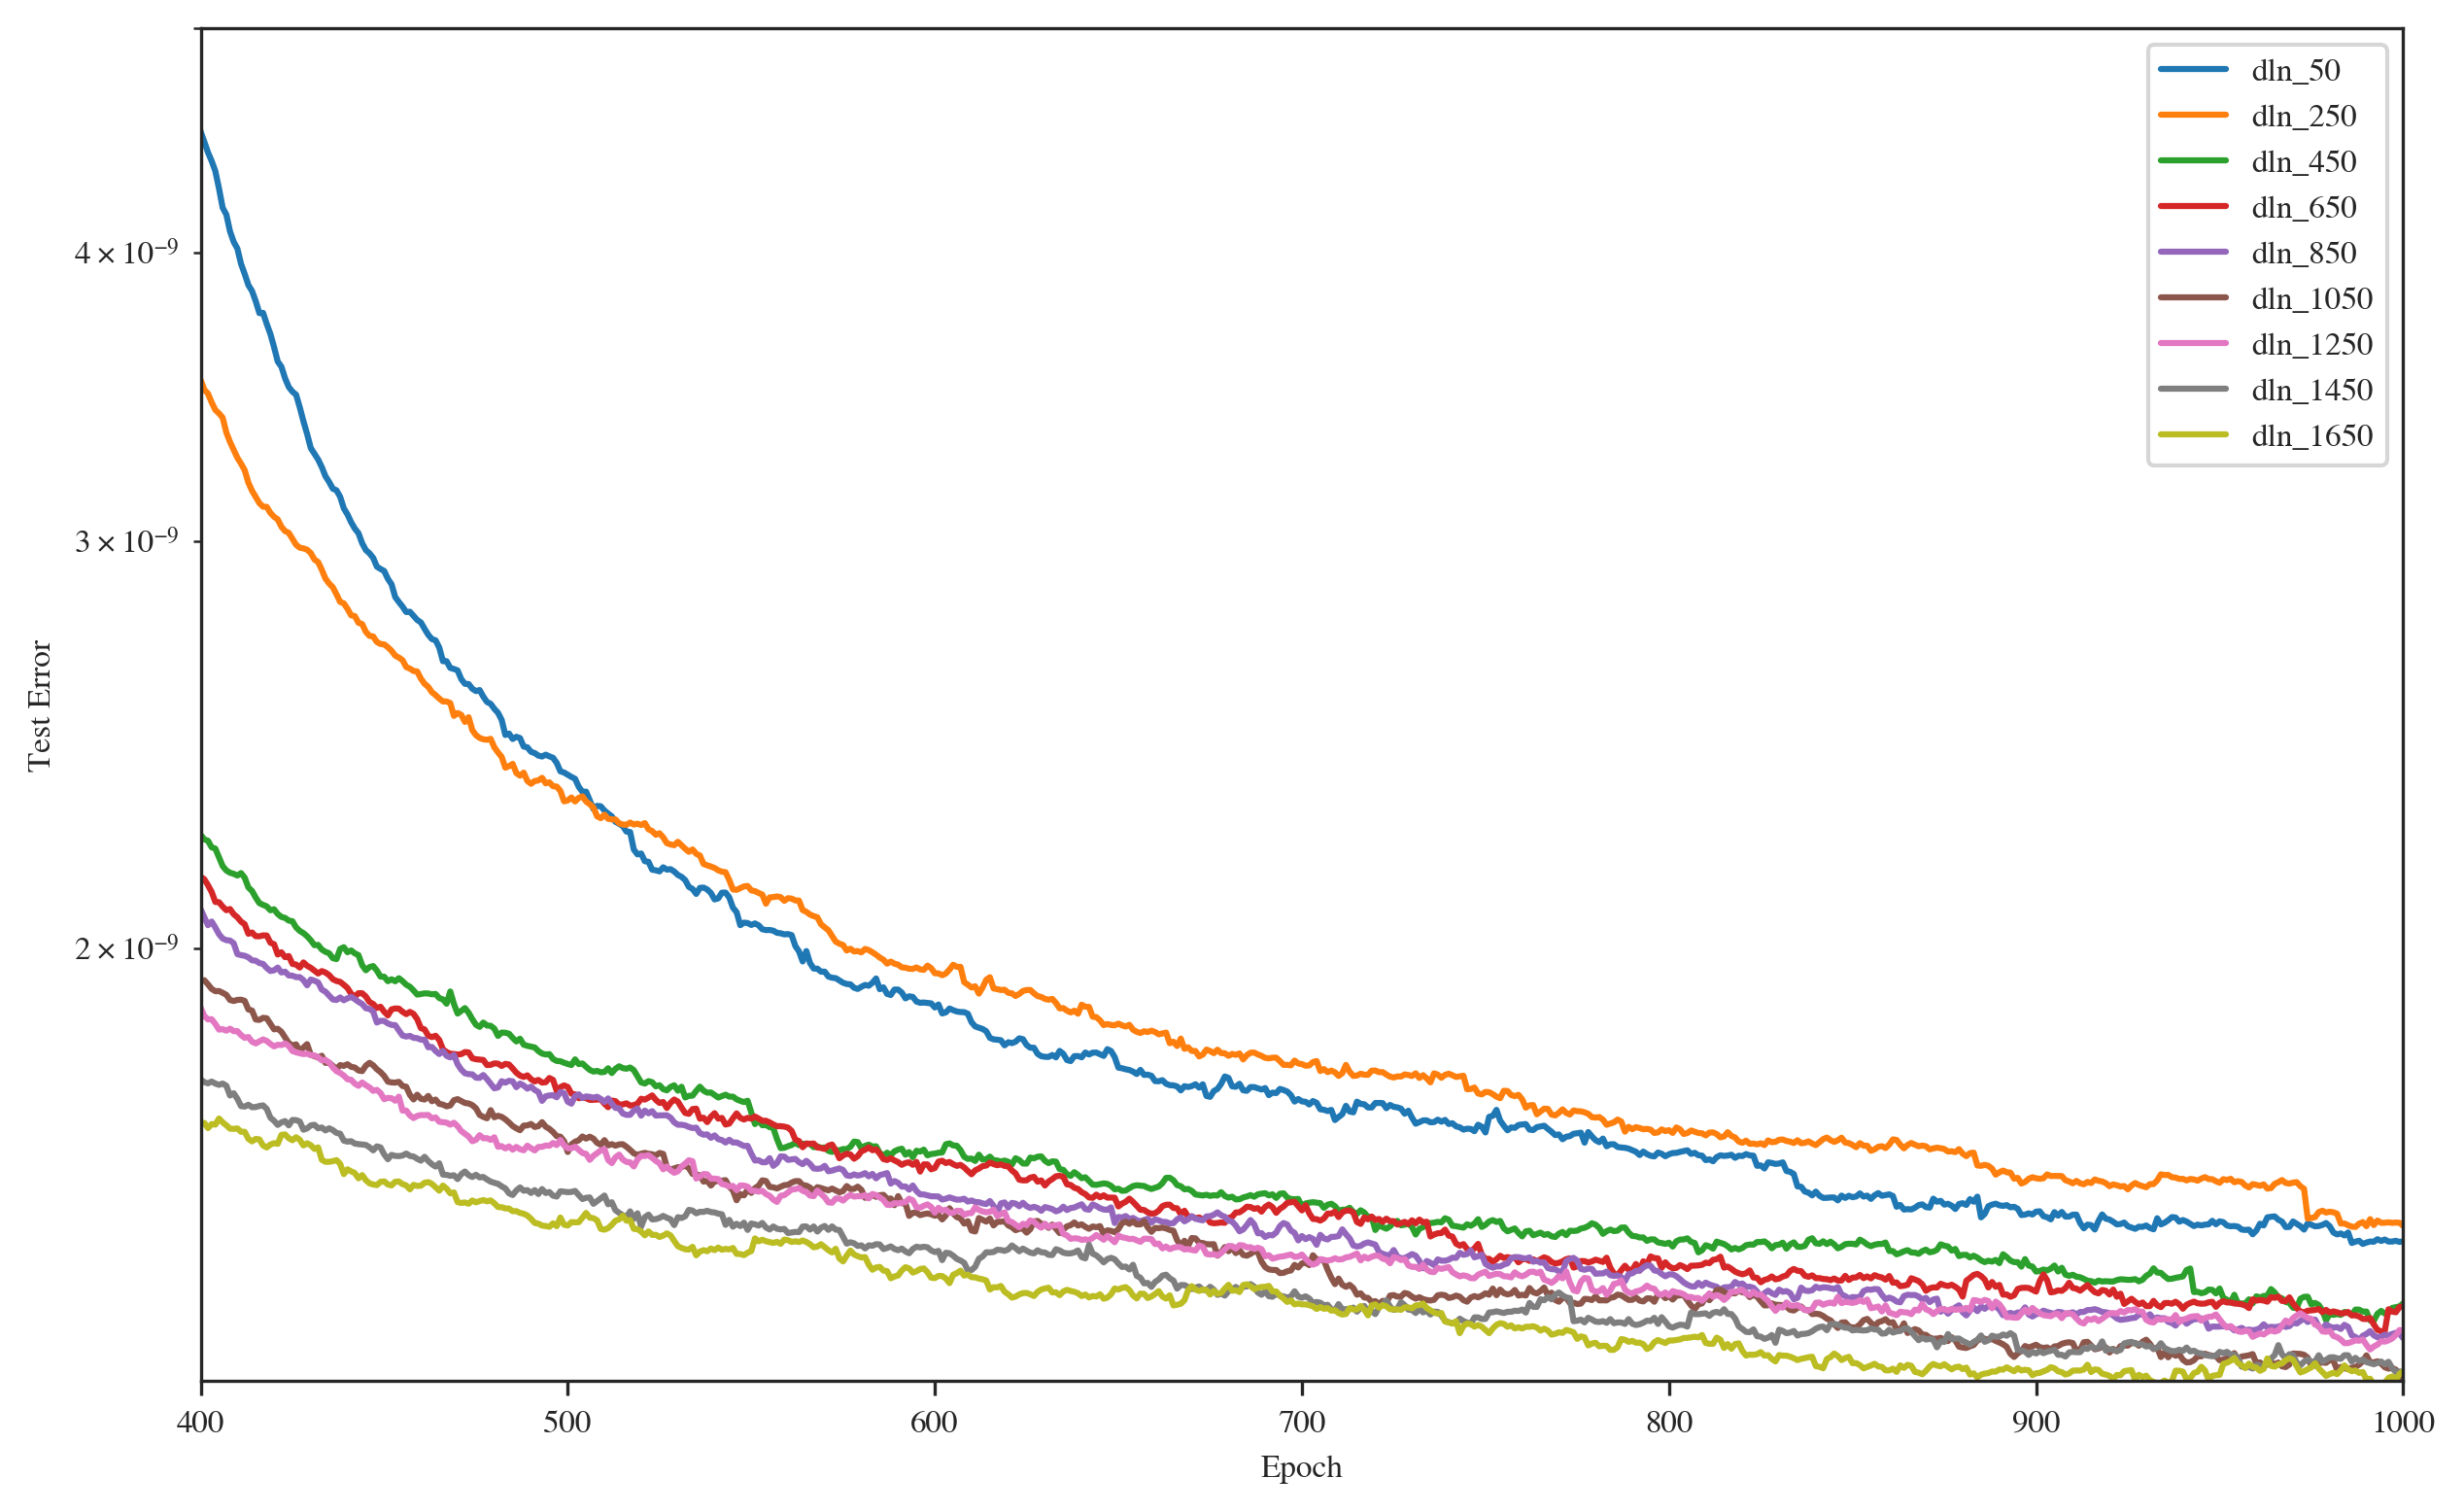

In [81]:
plt.figure(figsize = (some_multiplier_1 * WIDTH, some_multiplier_2 * HEIGHT))
plt.plot(epoch, model_losses[0])
plt.plot(epoch, model_losses[1])
plt.plot(epoch, model_losses[2])
plt.plot(epoch, model_losses[3])
plt.plot(epoch, model_losses[4])
plt.plot(epoch, model_losses[5])
plt.plot(epoch, model_losses[6])
plt.plot(epoch, model_losses[7])
plt.plot(epoch, model_losses[8])
#plt.plot(epoch, model_losses[9])
#plt.xscale('log')
plt.yscale('log')

plt.ylabel('Test Error')
plt.xlabel('Epoch')
plt.legend(labels = model_fig, loc="upper right")
seaborn.set_style("ticks")
plt.rcParams["font.family"] = "Times"
plt.rcParams['figure.dpi'] = 300
plt.rc('xtick', labelsize=8)
plt.rc('ytick', labelsize=8)
plt.rc('axes', labelsize=8)
plt.rc('legend', fontsize=8)
plt.rc('axes', titlesize=10)
plt.xlim([400, 1000])
plt.ylim([1.3*(10**-9),5*(10**-9)])
#plt.savefig("ten_percent_losses.pdf")
plt.show()

In [83]:
model_ref = ['dim10_1 - loss/test', 'dim10_2 - loss/test', 'dim10_3 - loss/test', 'dim10_4 - loss/test', 'dim10_5 - loss/test', 'dim10_6 - loss/test', 'dim10_7 - loss/test', 'dim10_8 - loss/test', 'dim10_9 - loss/test', 'dim10_10 - loss/test']
model_fig = ['dim10_50', 'dim10_250', 'dim10_450', 'dim10_650', 'dim10_850', 'dim10_1050', 'dim10_1250', 'dim10_1450', 'dim10_1650', 'dim10_1850']

model_losses = []
for i in model_ref:
    model_loss = dim10_metrics[i].values
    model_losses.append(model_loss.transpose())

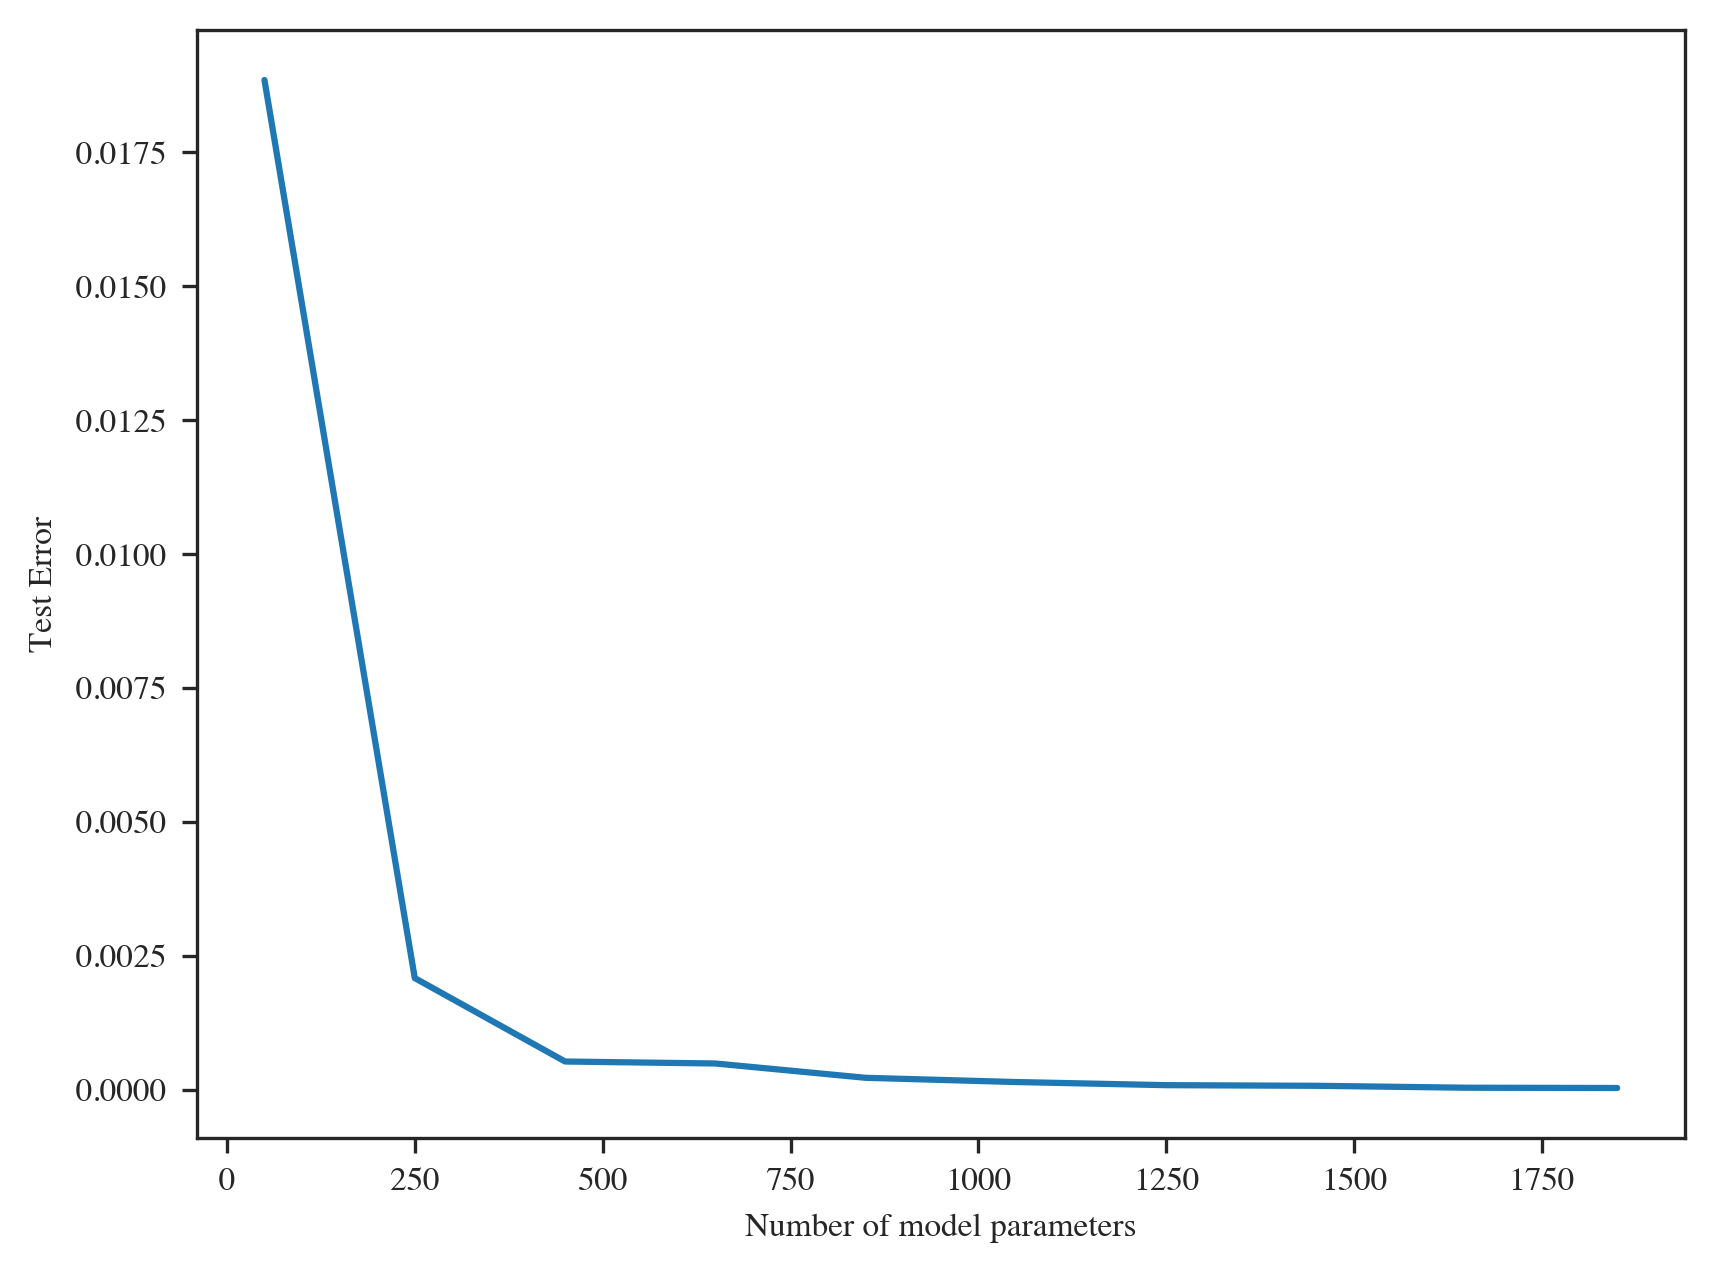

In [160]:
plt.plot(num_params, model_losses)
plt.ylabel('Test Error')
plt.xlabel('Number of model parameters')
#plt.legend(labels = model_fig, loc="upper right")
seaborn.set_style("ticks")
plt.rcParams["font.family"] = "Times"
plt.rcParams['figure.dpi'] = 300
plt.rc('xtick', labelsize=8)
plt.rc('ytick', labelsize=8)
plt.rc('axes', labelsize=8)
#plt.rc('legend', fontsize=8)
plt.rc('axes', titlesize=10)
plt.show()

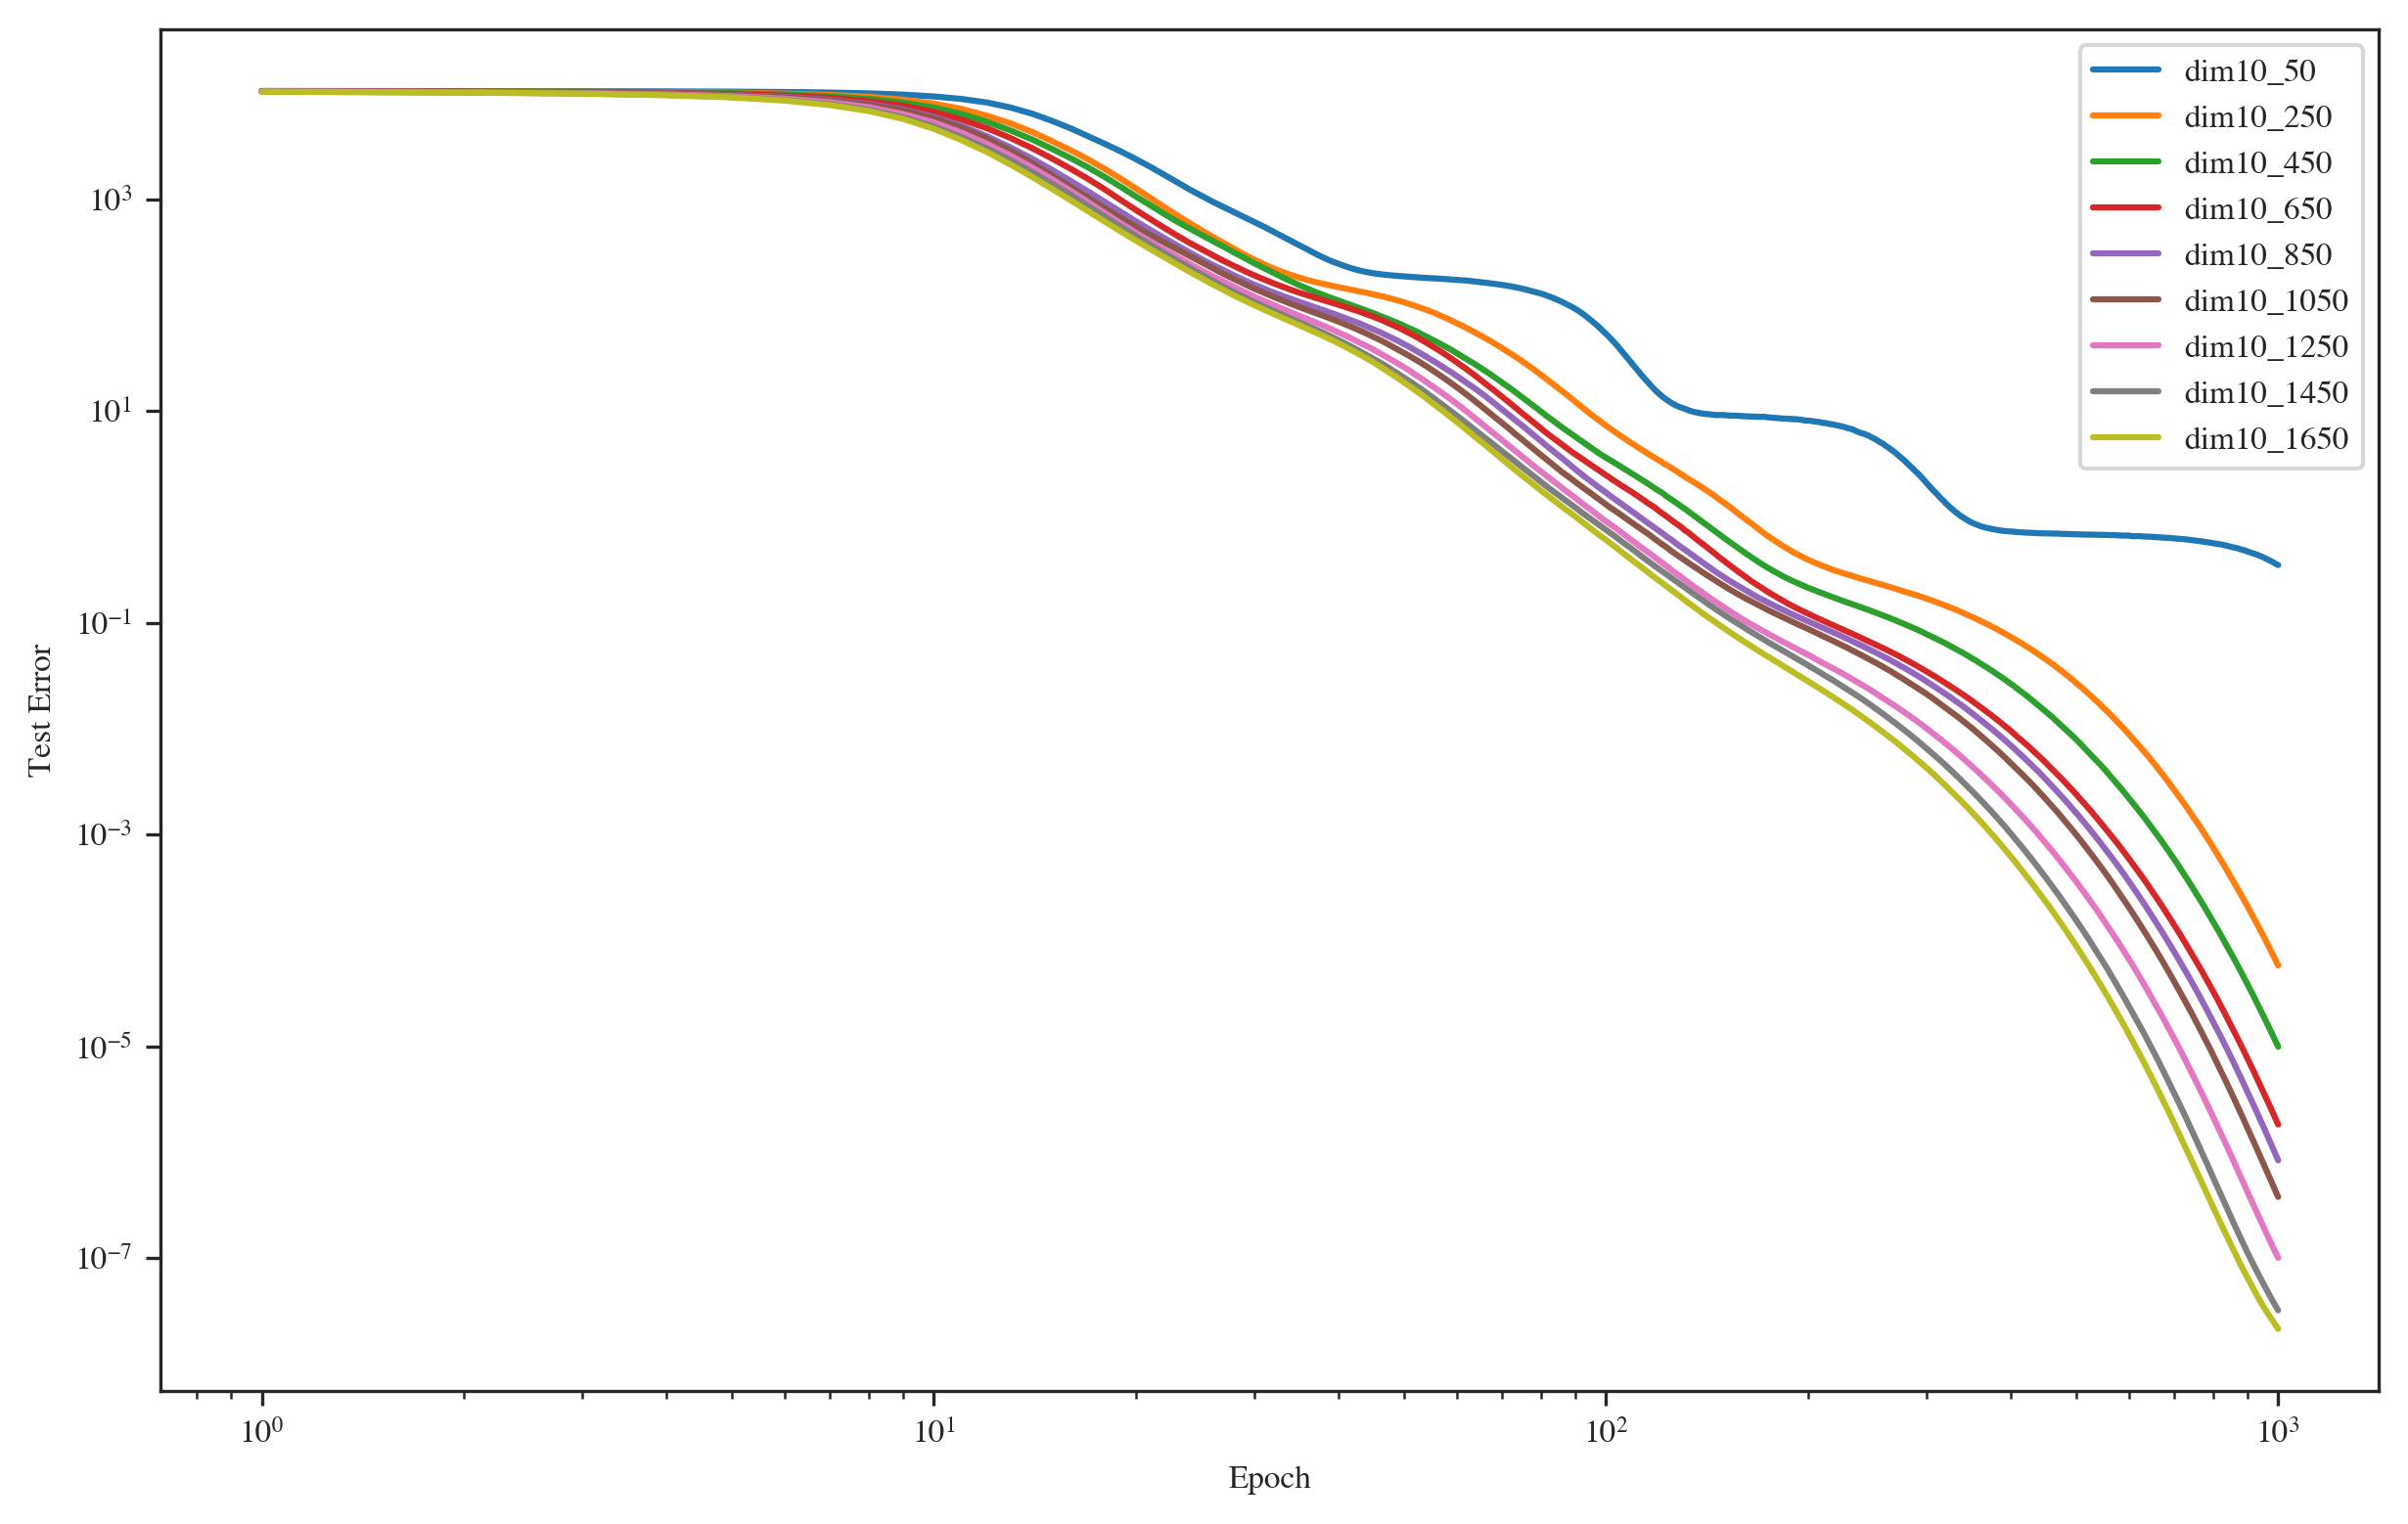

In [84]:
plt.figure(figsize = (some_multiplier_1 * WIDTH, some_multiplier_2 * HEIGHT))
plt.plot(epoch, model_losses[0])
plt.plot(epoch, model_losses[1])
plt.plot(epoch, model_losses[2])
plt.plot(epoch, model_losses[3])
plt.plot(epoch, model_losses[4])
plt.plot(epoch, model_losses[5])
plt.plot(epoch, model_losses[6])
plt.plot(epoch, model_losses[7])
plt.plot(epoch, model_losses[8])
#plt.plot(epoch, model_losses[9])
plt.xscale('log')
plt.yscale('log')

plt.ylabel('Test Error')
plt.xlabel('Epoch')
plt.legend(labels = model_fig, loc="upper right")
seaborn.set_style("ticks")
plt.rcParams["font.family"] = "Times"
plt.rcParams['figure.dpi'] = 300
plt.rc('xtick', labelsize=8)
plt.rc('ytick', labelsize=8)
plt.rc('axes', labelsize=8)
plt.rc('legend', fontsize=8)
plt.rc('axes', titlesize=10)

#plt.savefig("ten_percent_losses.pdf")
plt.show()

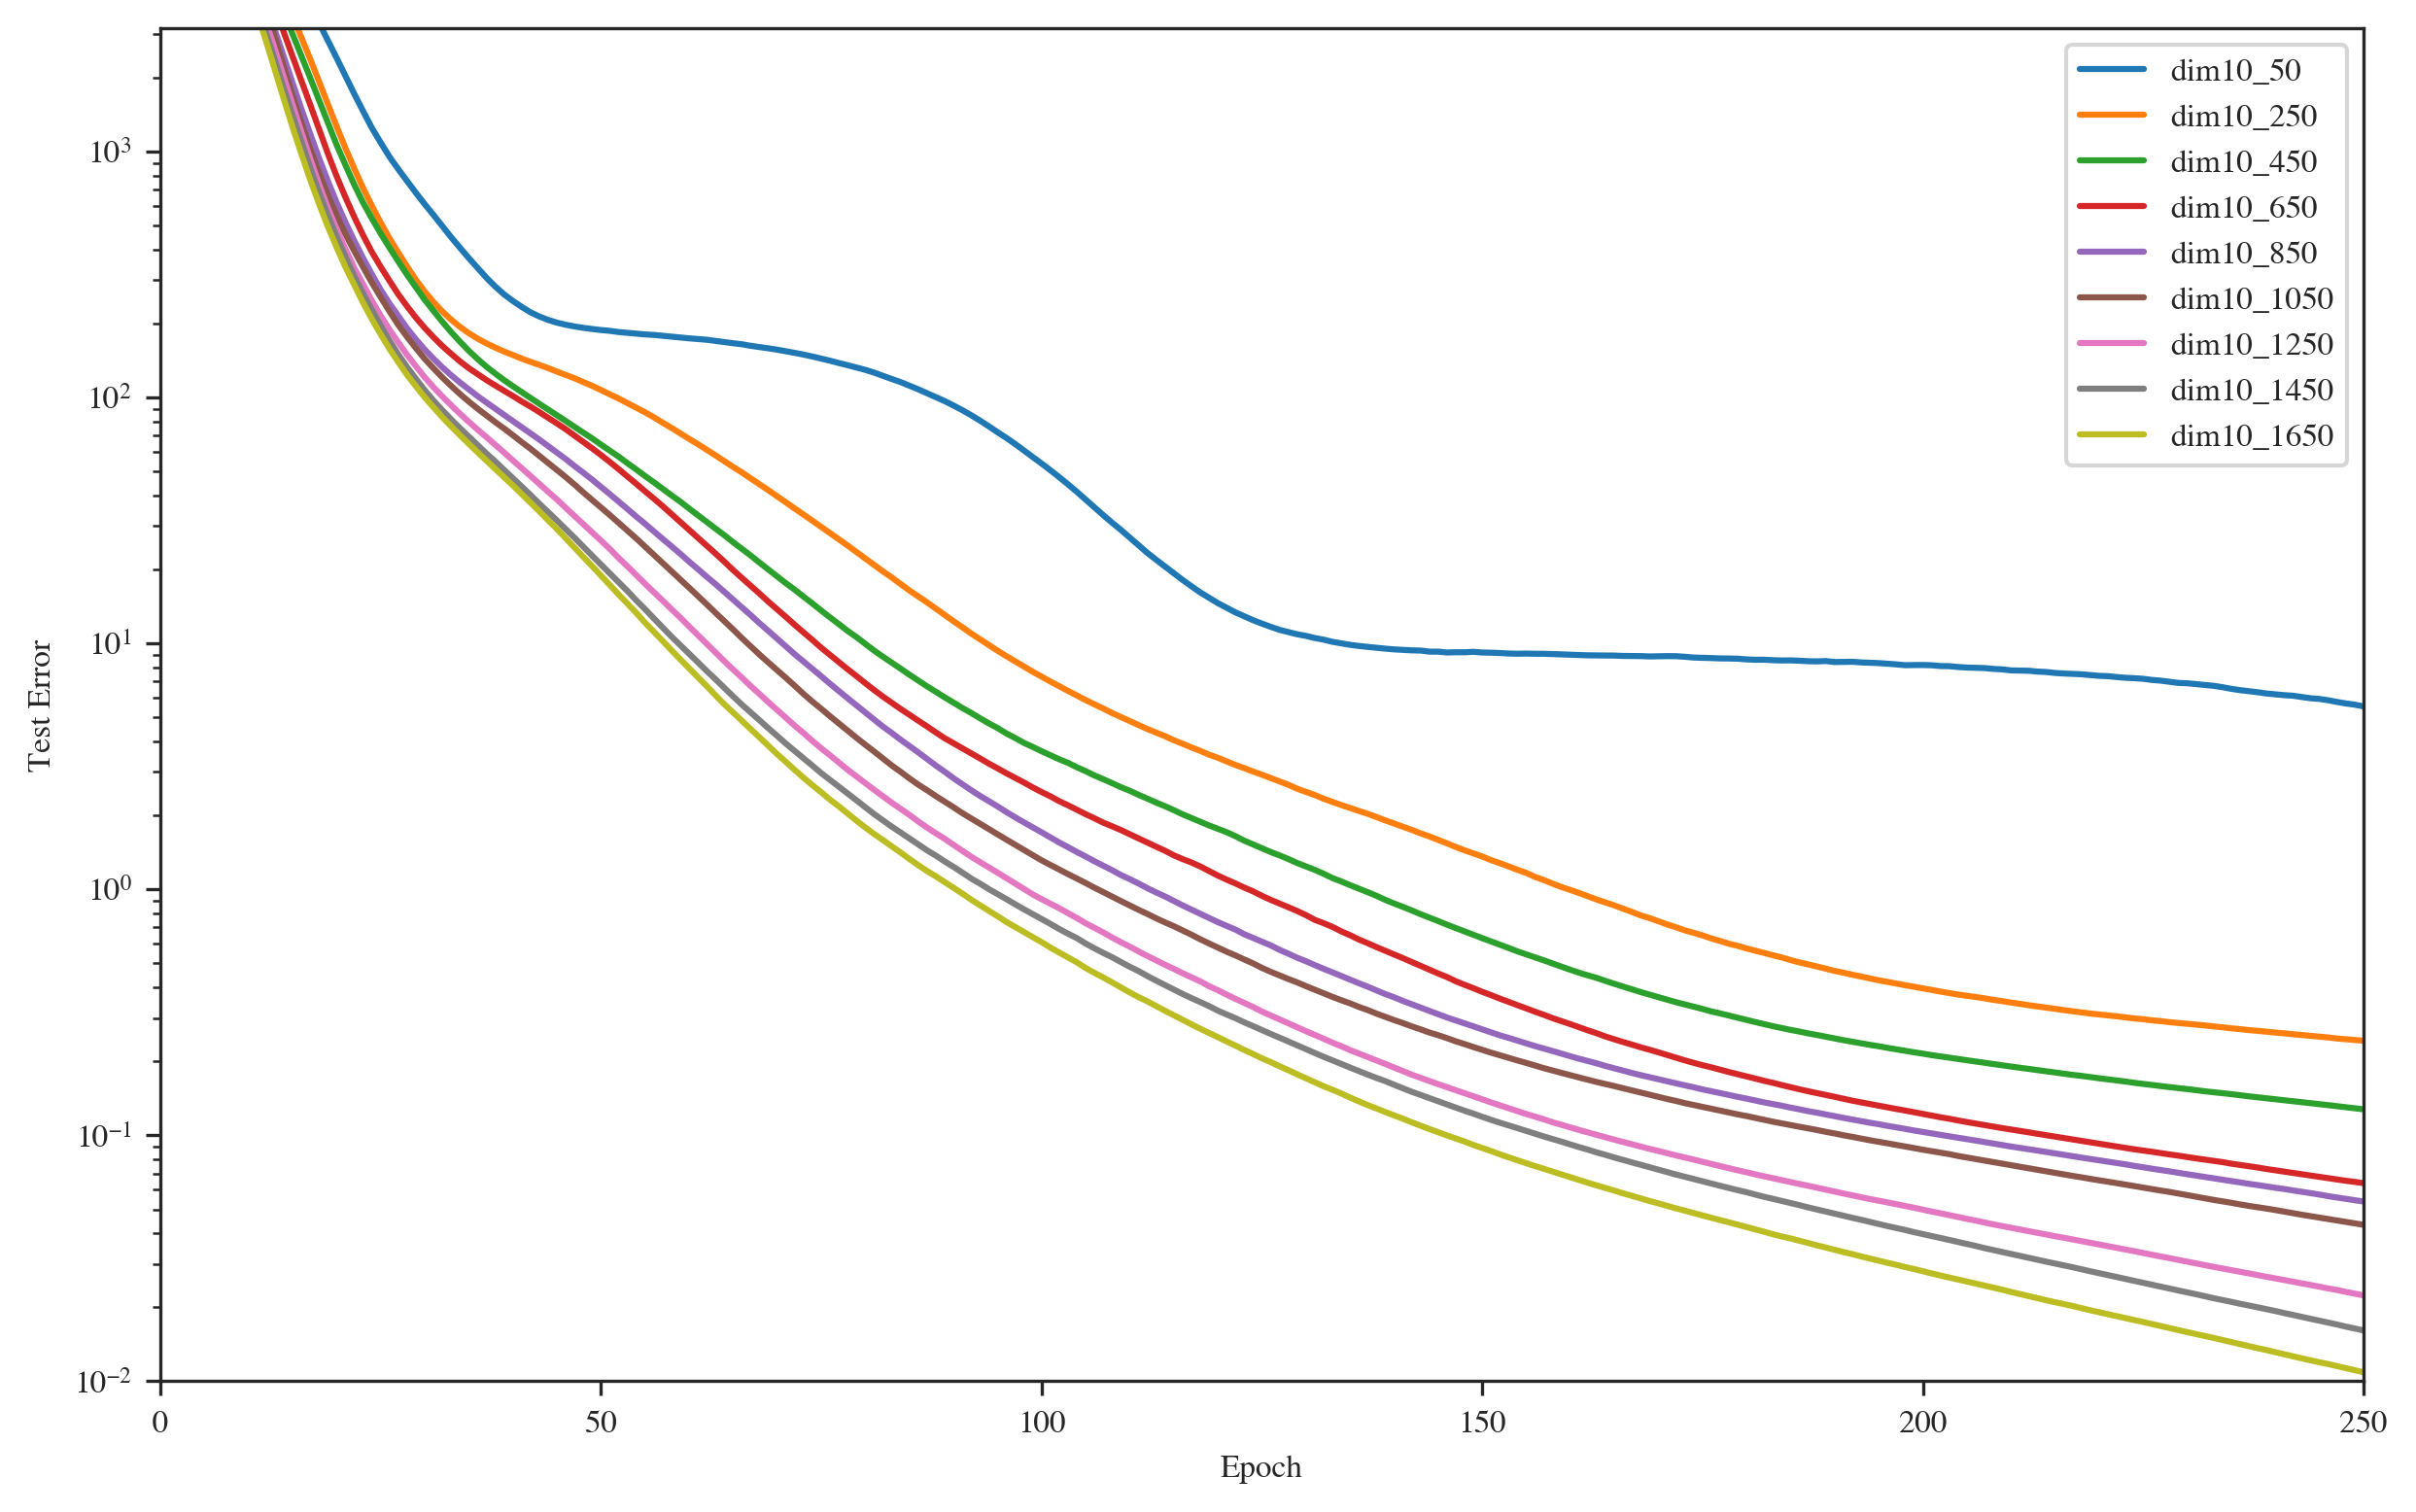

In [89]:
plt.figure(figsize = (some_multiplier_1 * WIDTH, some_multiplier_2 * HEIGHT))
plt.plot(epoch, model_losses[0])
plt.plot(epoch, model_losses[1])
plt.plot(epoch, model_losses[2])
plt.plot(epoch, model_losses[3])
plt.plot(epoch, model_losses[4])
plt.plot(epoch, model_losses[5])
plt.plot(epoch, model_losses[6])
plt.plot(epoch, model_losses[7])
plt.plot(epoch, model_losses[8])
#plt.plot(epoch, model_losses[9])
#plt.xscale('log')
plt.yscale('log')

plt.ylabel('Test Error')
plt.xlabel('Epoch')
plt.legend(labels = model_fig, loc="upper right")
seaborn.set_style("ticks")
plt.rcParams["font.family"] = "Times"
plt.rcParams['figure.dpi'] = 300
plt.rc('xtick', labelsize=8)
plt.rc('ytick', labelsize=8)
plt.rc('axes', labelsize=8)
plt.rc('legend', fontsize=8)
plt.rc('axes', titlesize=10)
plt.xlim([0, 250])
plt.ylim([10**-2,10**3.5])
#plt.savefig("ten_percent_losses.pdf")
plt.show()

In [91]:
model_ref = ['dim20_1 - loss/test', 'dim20_2 - loss/test', 'dim20_3 - loss/test', 'dim20_4 - loss/test', 'dim20_5 - loss/test', 'dim20_6 - loss/test', 'dim20_7 - loss/test', 'dim20_8 - loss/test', 'dim20_9 - loss/test', 'dim20_10 - loss/test']
model_fig = ['dim20_50', 'dim20_250', 'dim20_450', 'dim20_650', 'dim20_850', 'dim20_1050', 'dim20_1250', 'dim20_1450', 'dim20_1650', 'dim20_1850']

model_losses = []
for i in model_ref:
    model_loss = dim20_metrics[i].values
    model_losses.append(model_loss.transpose())

In [159]:
model_ref = ['dim20_1 - loss/test', 'dim20_2 - loss/test', 'dim20_3 - loss/test', 'dim20_4 - loss/test', 'dim20_5 - loss/test', 'dim20_6 - loss/test', 'dim20_7 - loss/test', 'dim20_8 - loss/test', 'dim20_9 - loss/test', 'dim20_10 - loss/test']
model_fig = ['dim20_50', 'dim20_250', 'dim20_450', 'dim20_650', 'dim20_850', 'dim20_1050', 'dim20_1250', 'dim20_1450', 'dim20_1650', 'dim20_1850']

model_losses = []
for i in model_ref:
    model_loss = dim20_metrics[i].values[-1]
    model_losses.append(model_loss.transpose())

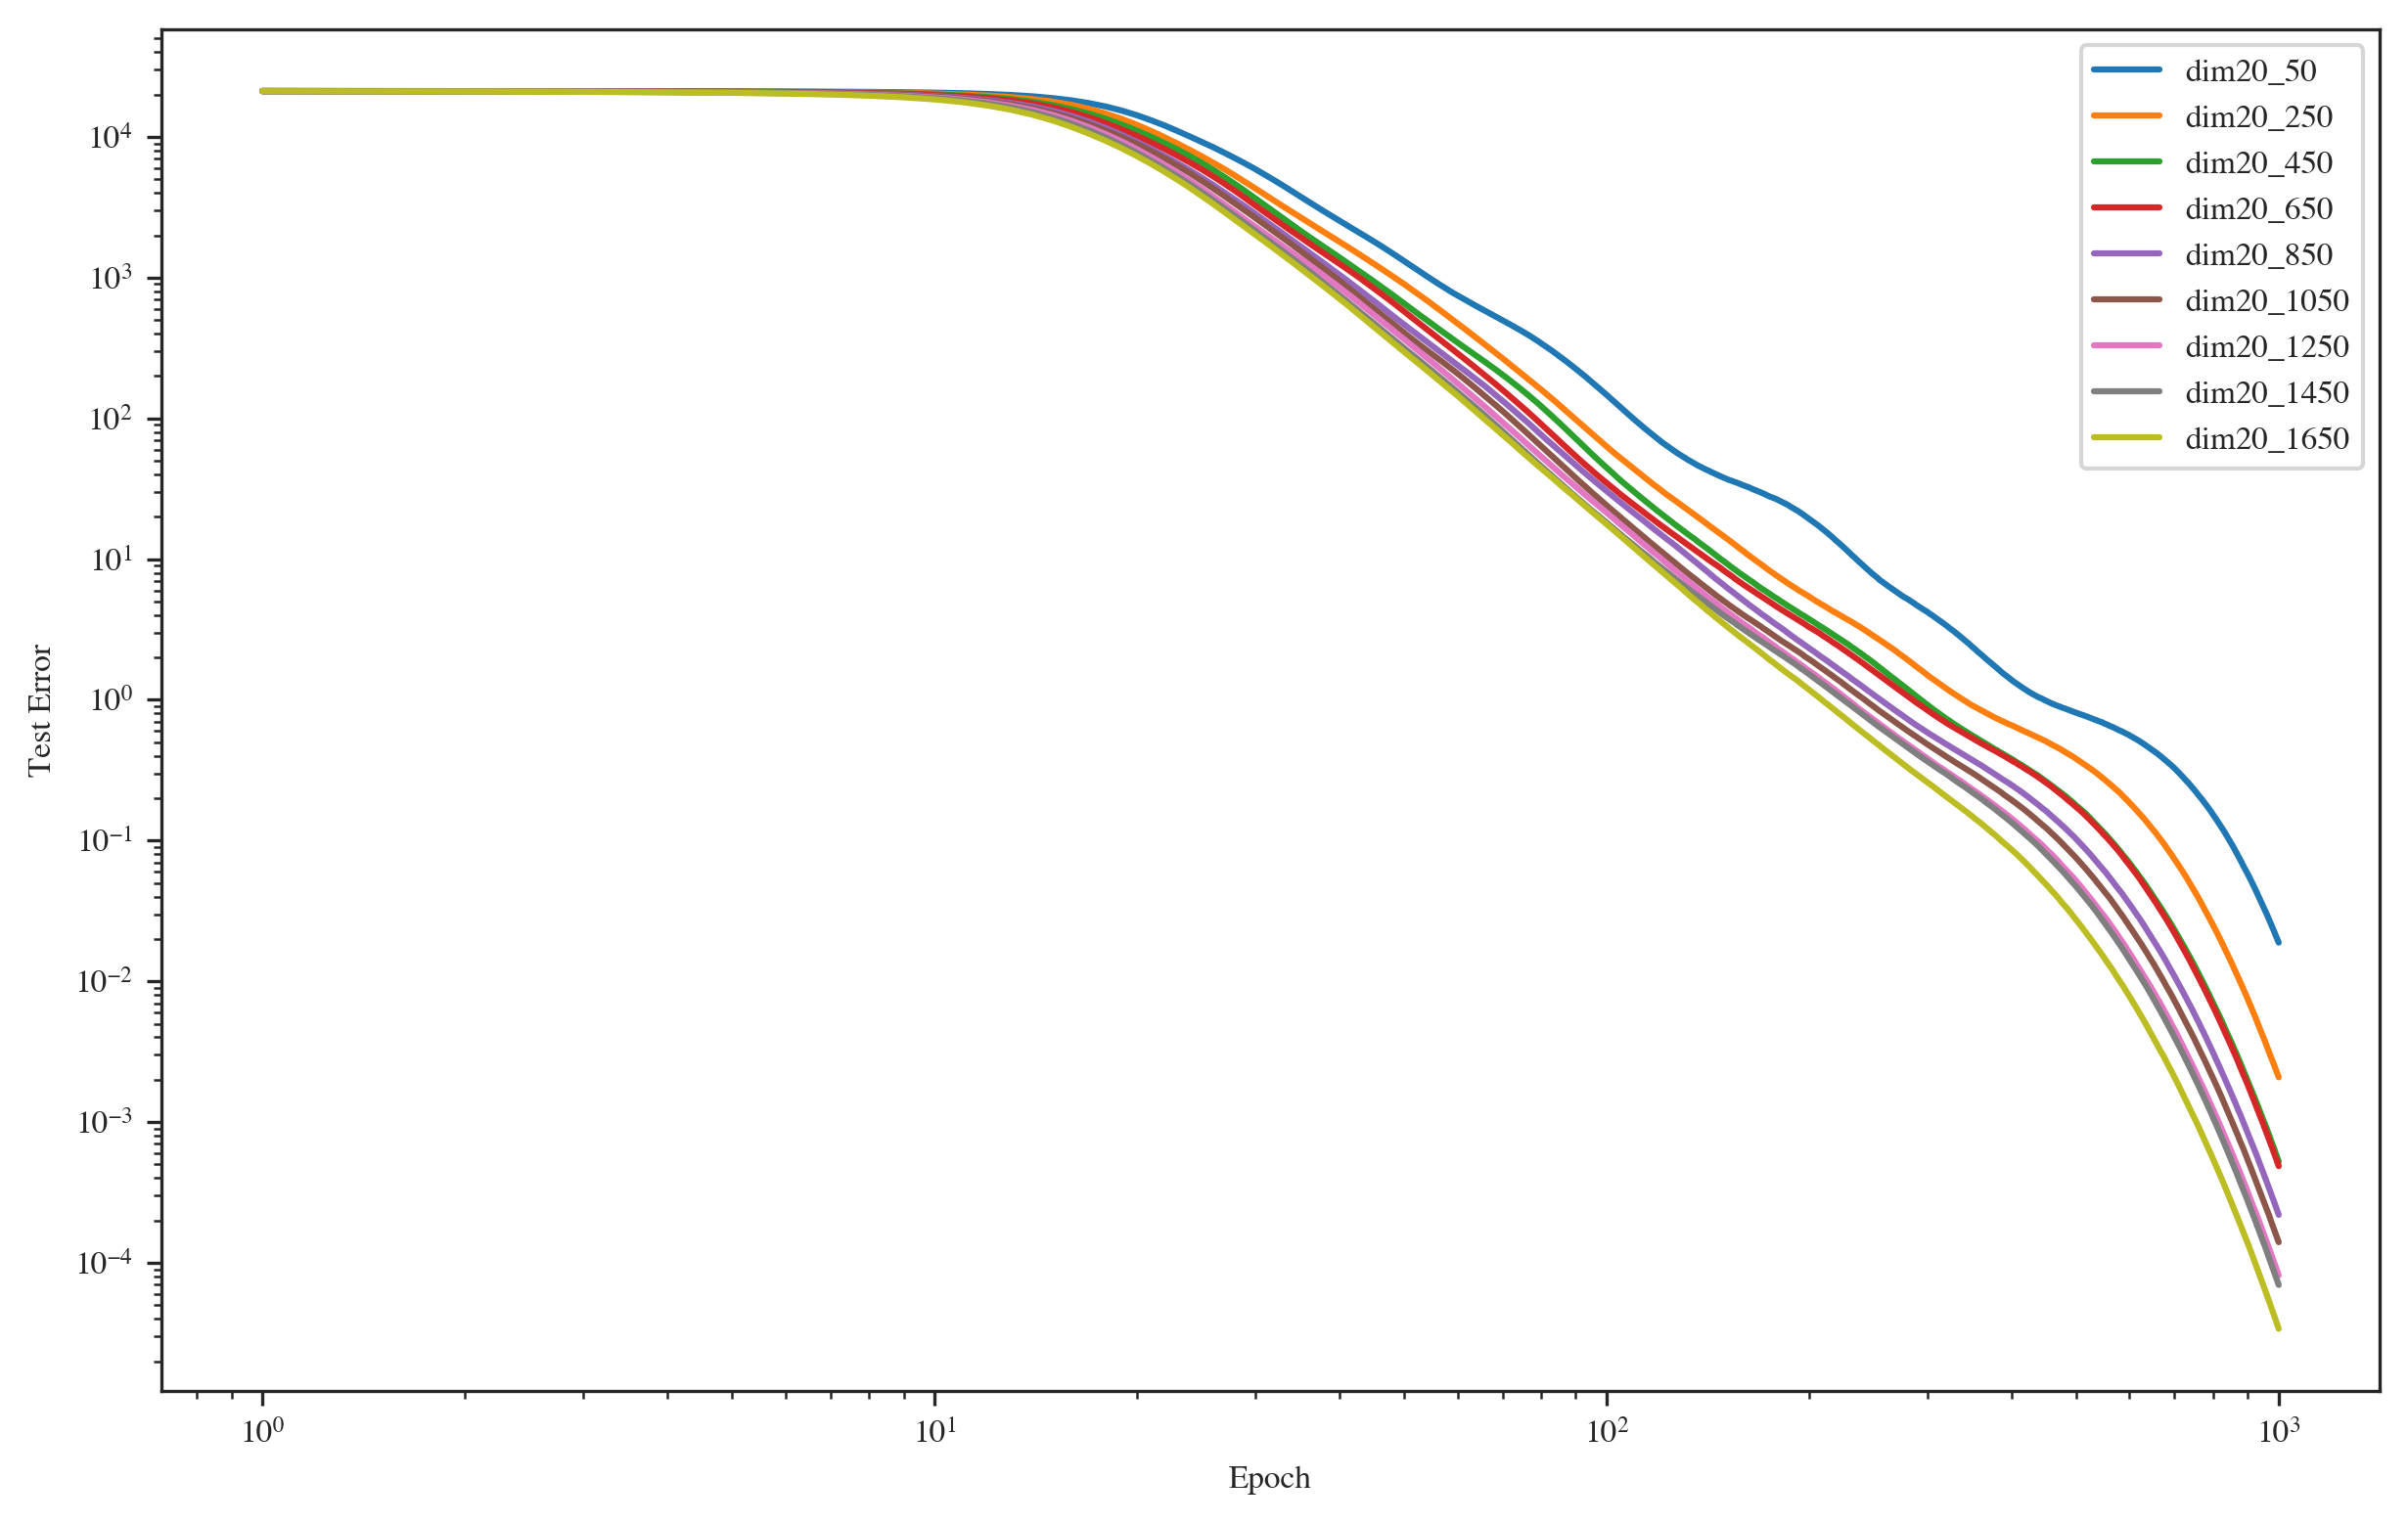

In [92]:
plt.figure(figsize = (some_multiplier_1 * WIDTH, some_multiplier_2 * HEIGHT))
plt.plot(epoch, model_losses[0])
plt.plot(epoch, model_losses[1])
plt.plot(epoch, model_losses[2])
plt.plot(epoch, model_losses[3])
plt.plot(epoch, model_losses[4])
plt.plot(epoch, model_losses[5])
plt.plot(epoch, model_losses[6])
plt.plot(epoch, model_losses[7])
plt.plot(epoch, model_losses[8])
#plt.plot(epoch, model_losses[9])
plt.xscale('log')
plt.yscale('log')

plt.ylabel('Test Error')
plt.xlabel('Epoch')
plt.legend(labels = model_fig, loc="upper right")
seaborn.set_style("ticks")
plt.rcParams["font.family"] = "Times"
plt.rcParams['figure.dpi'] = 300
plt.rc('xtick', labelsize=8)
plt.rc('ytick', labelsize=8)
plt.rc('axes', labelsize=8)
plt.rc('legend', fontsize=8)
plt.rc('axes', titlesize=10)

#plt.savefig("ten_percent_losses.pdf")
plt.show()

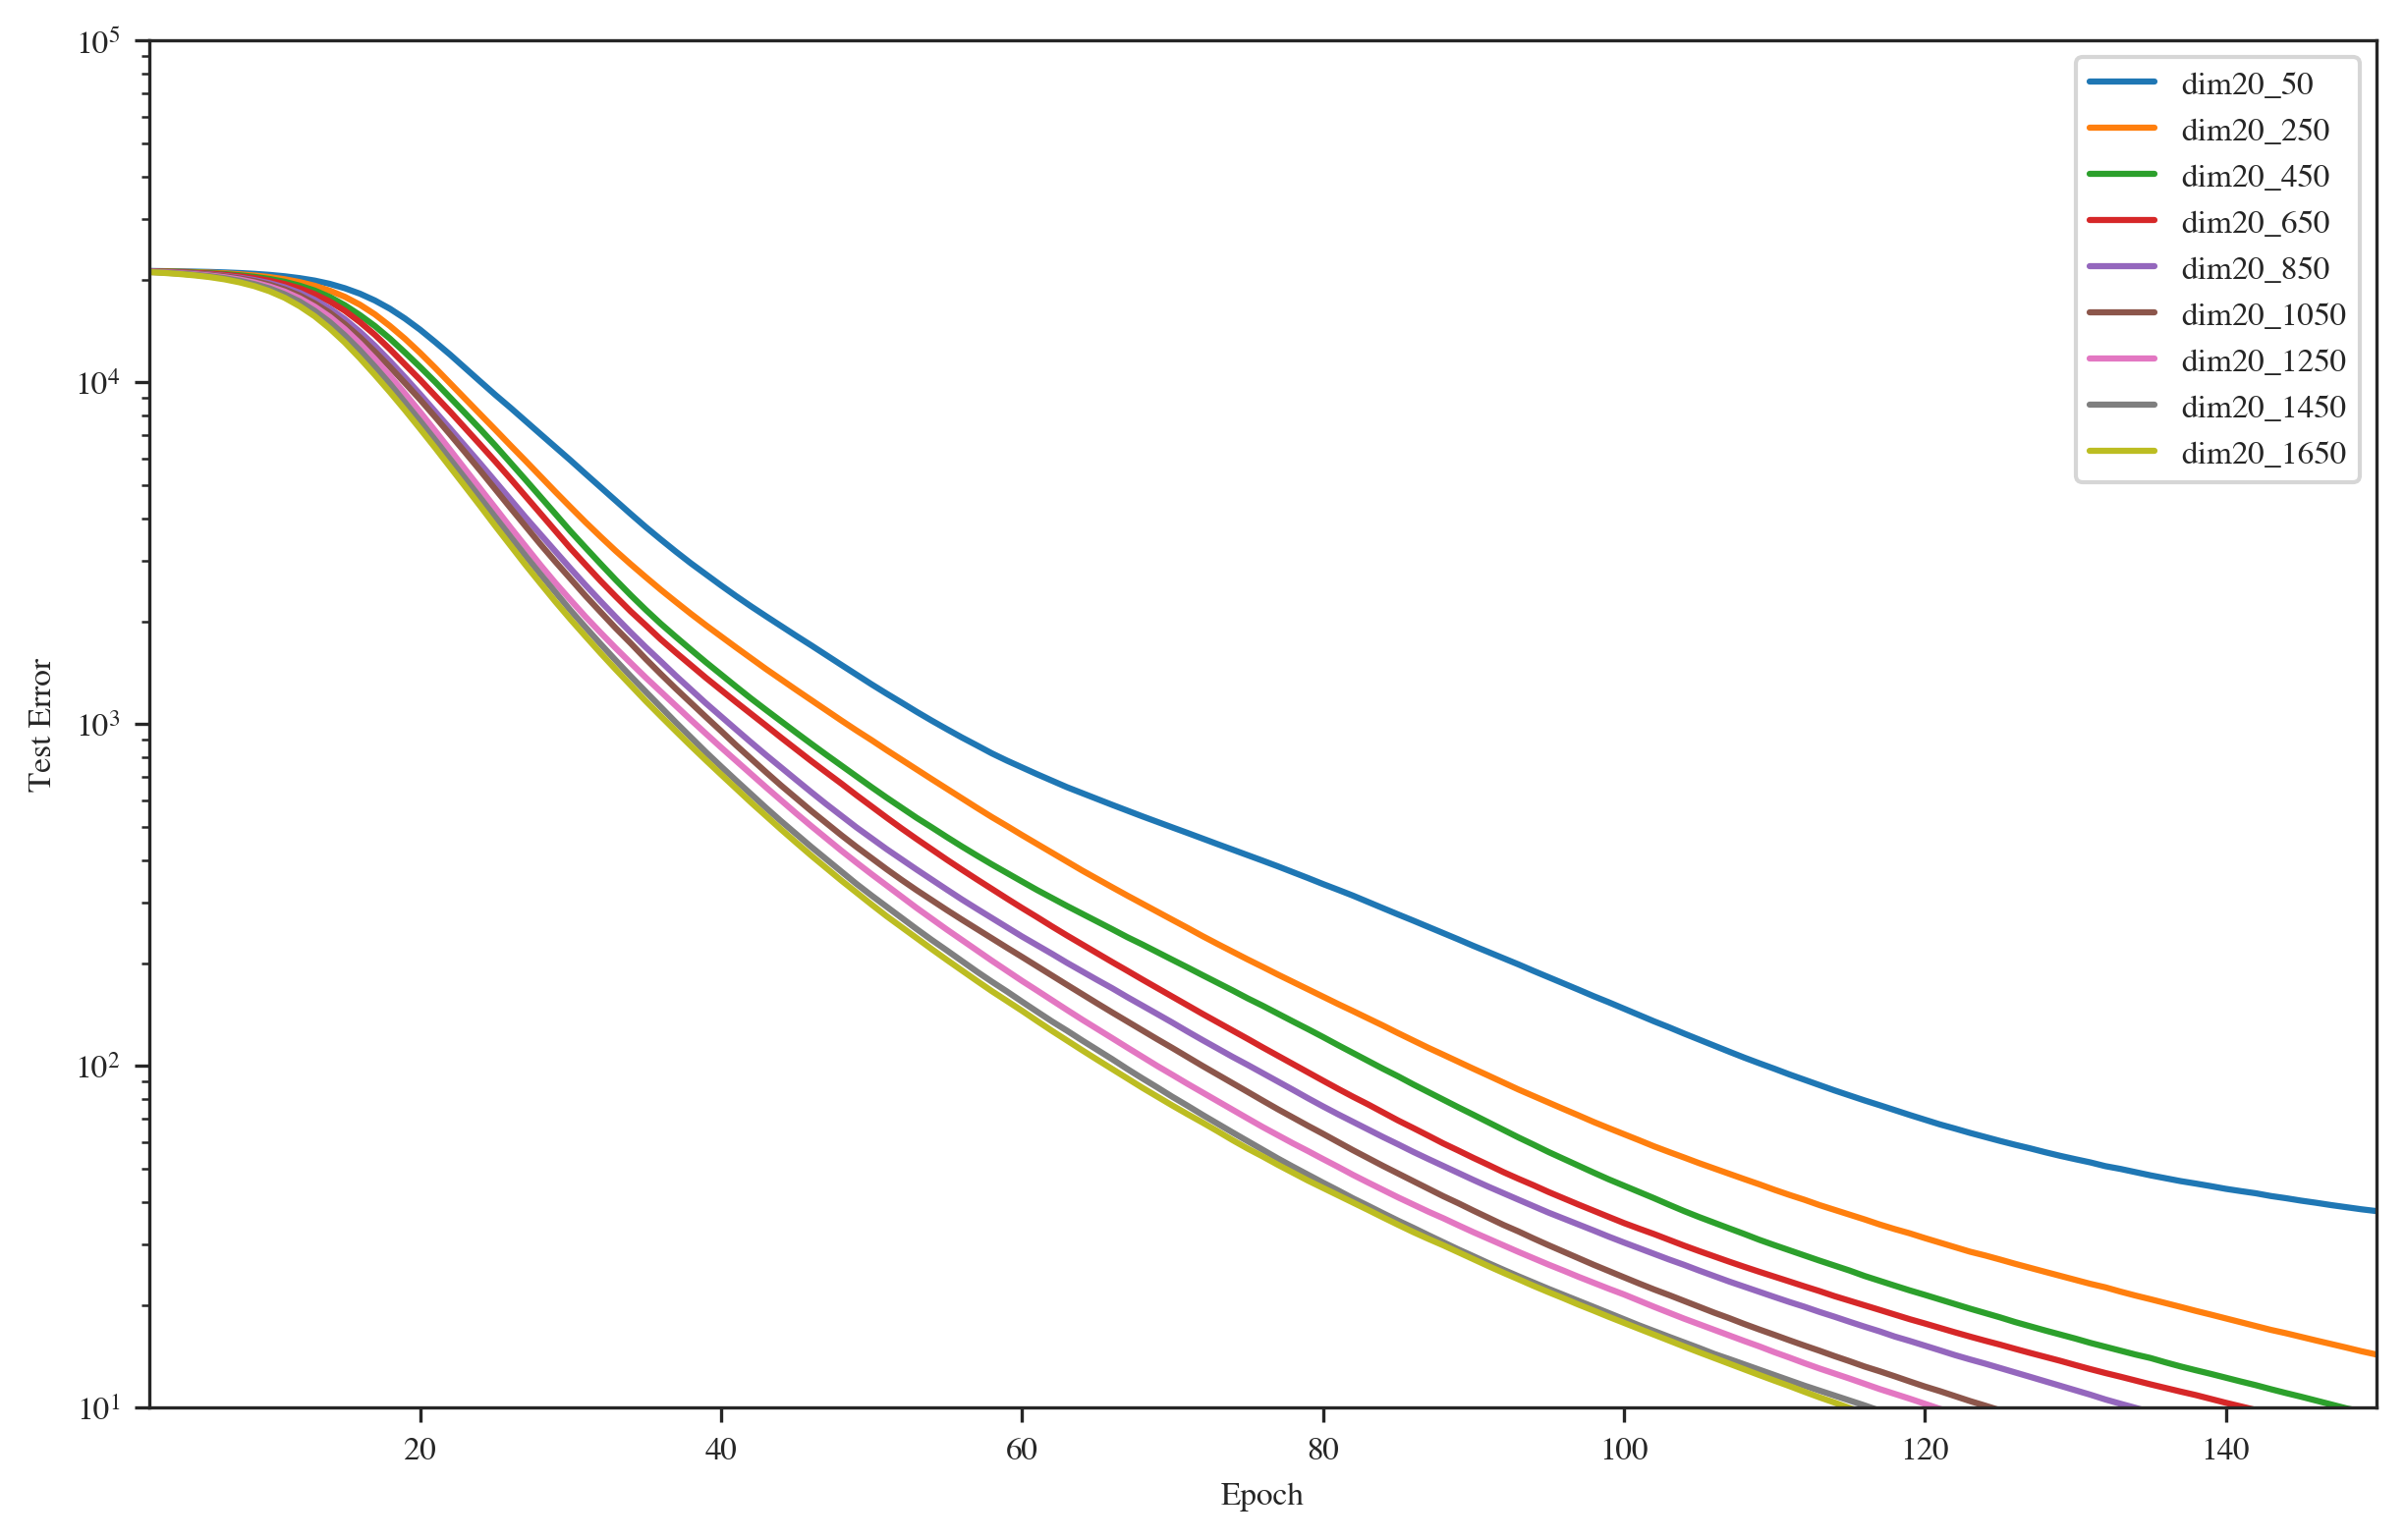

In [100]:
plt.figure(figsize = (some_multiplier_1 * WIDTH, some_multiplier_2 * HEIGHT))
plt.plot(epoch, model_losses[0])
plt.plot(epoch, model_losses[1])
plt.plot(epoch, model_losses[2])
plt.plot(epoch, model_losses[3])
plt.plot(epoch, model_losses[4])
plt.plot(epoch, model_losses[5])
plt.plot(epoch, model_losses[6])
plt.plot(epoch, model_losses[7])
plt.plot(epoch, model_losses[8])
#plt.plot(epoch, model_losses[9])
#plt.xscale('log')
plt.yscale('log')

plt.ylabel('Test Error')
plt.xlabel('Epoch')
plt.legend(labels = model_fig, loc="upper right")
seaborn.set_style("ticks")
plt.rcParams["font.family"] = "Times"
plt.rcParams['figure.dpi'] = 300
plt.rc('xtick', labelsize=8)
plt.rc('ytick', labelsize=8)
plt.rc('axes', labelsize=8)
plt.rc('legend', fontsize=8)
plt.rc('axes', titlesize=10)
plt.xlim([2, 150])
plt.ylim([10,10**5])
#plt.savefig("ten_percent_losses.pdf")
plt.show()

In [102]:
model_ref = ['dim40_1 - loss/test', 'dim40_2 - loss/test', 'dim40_3 - loss/test', 'dim40_4 - loss/test', 'dim40_5 - loss/test', 'dim40_6 - loss/test', 'dim40_7 - loss/test', 'dim40_8 - loss/test', 'dim40_9 - loss/test', 'dim40_10 - loss/test']
model_fig = ['dim40_50', 'dim40_250', 'dim40_450', 'dim40_650', 'dim40_850', 'dim40_1050', 'dim40_1250', 'dim40_1450', 'dim40_1650', 'dim40_1850']

model_losses = []
for i in model_ref:
    model_loss = dim40_metrics[i].values
    model_losses.append(model_loss.transpose())

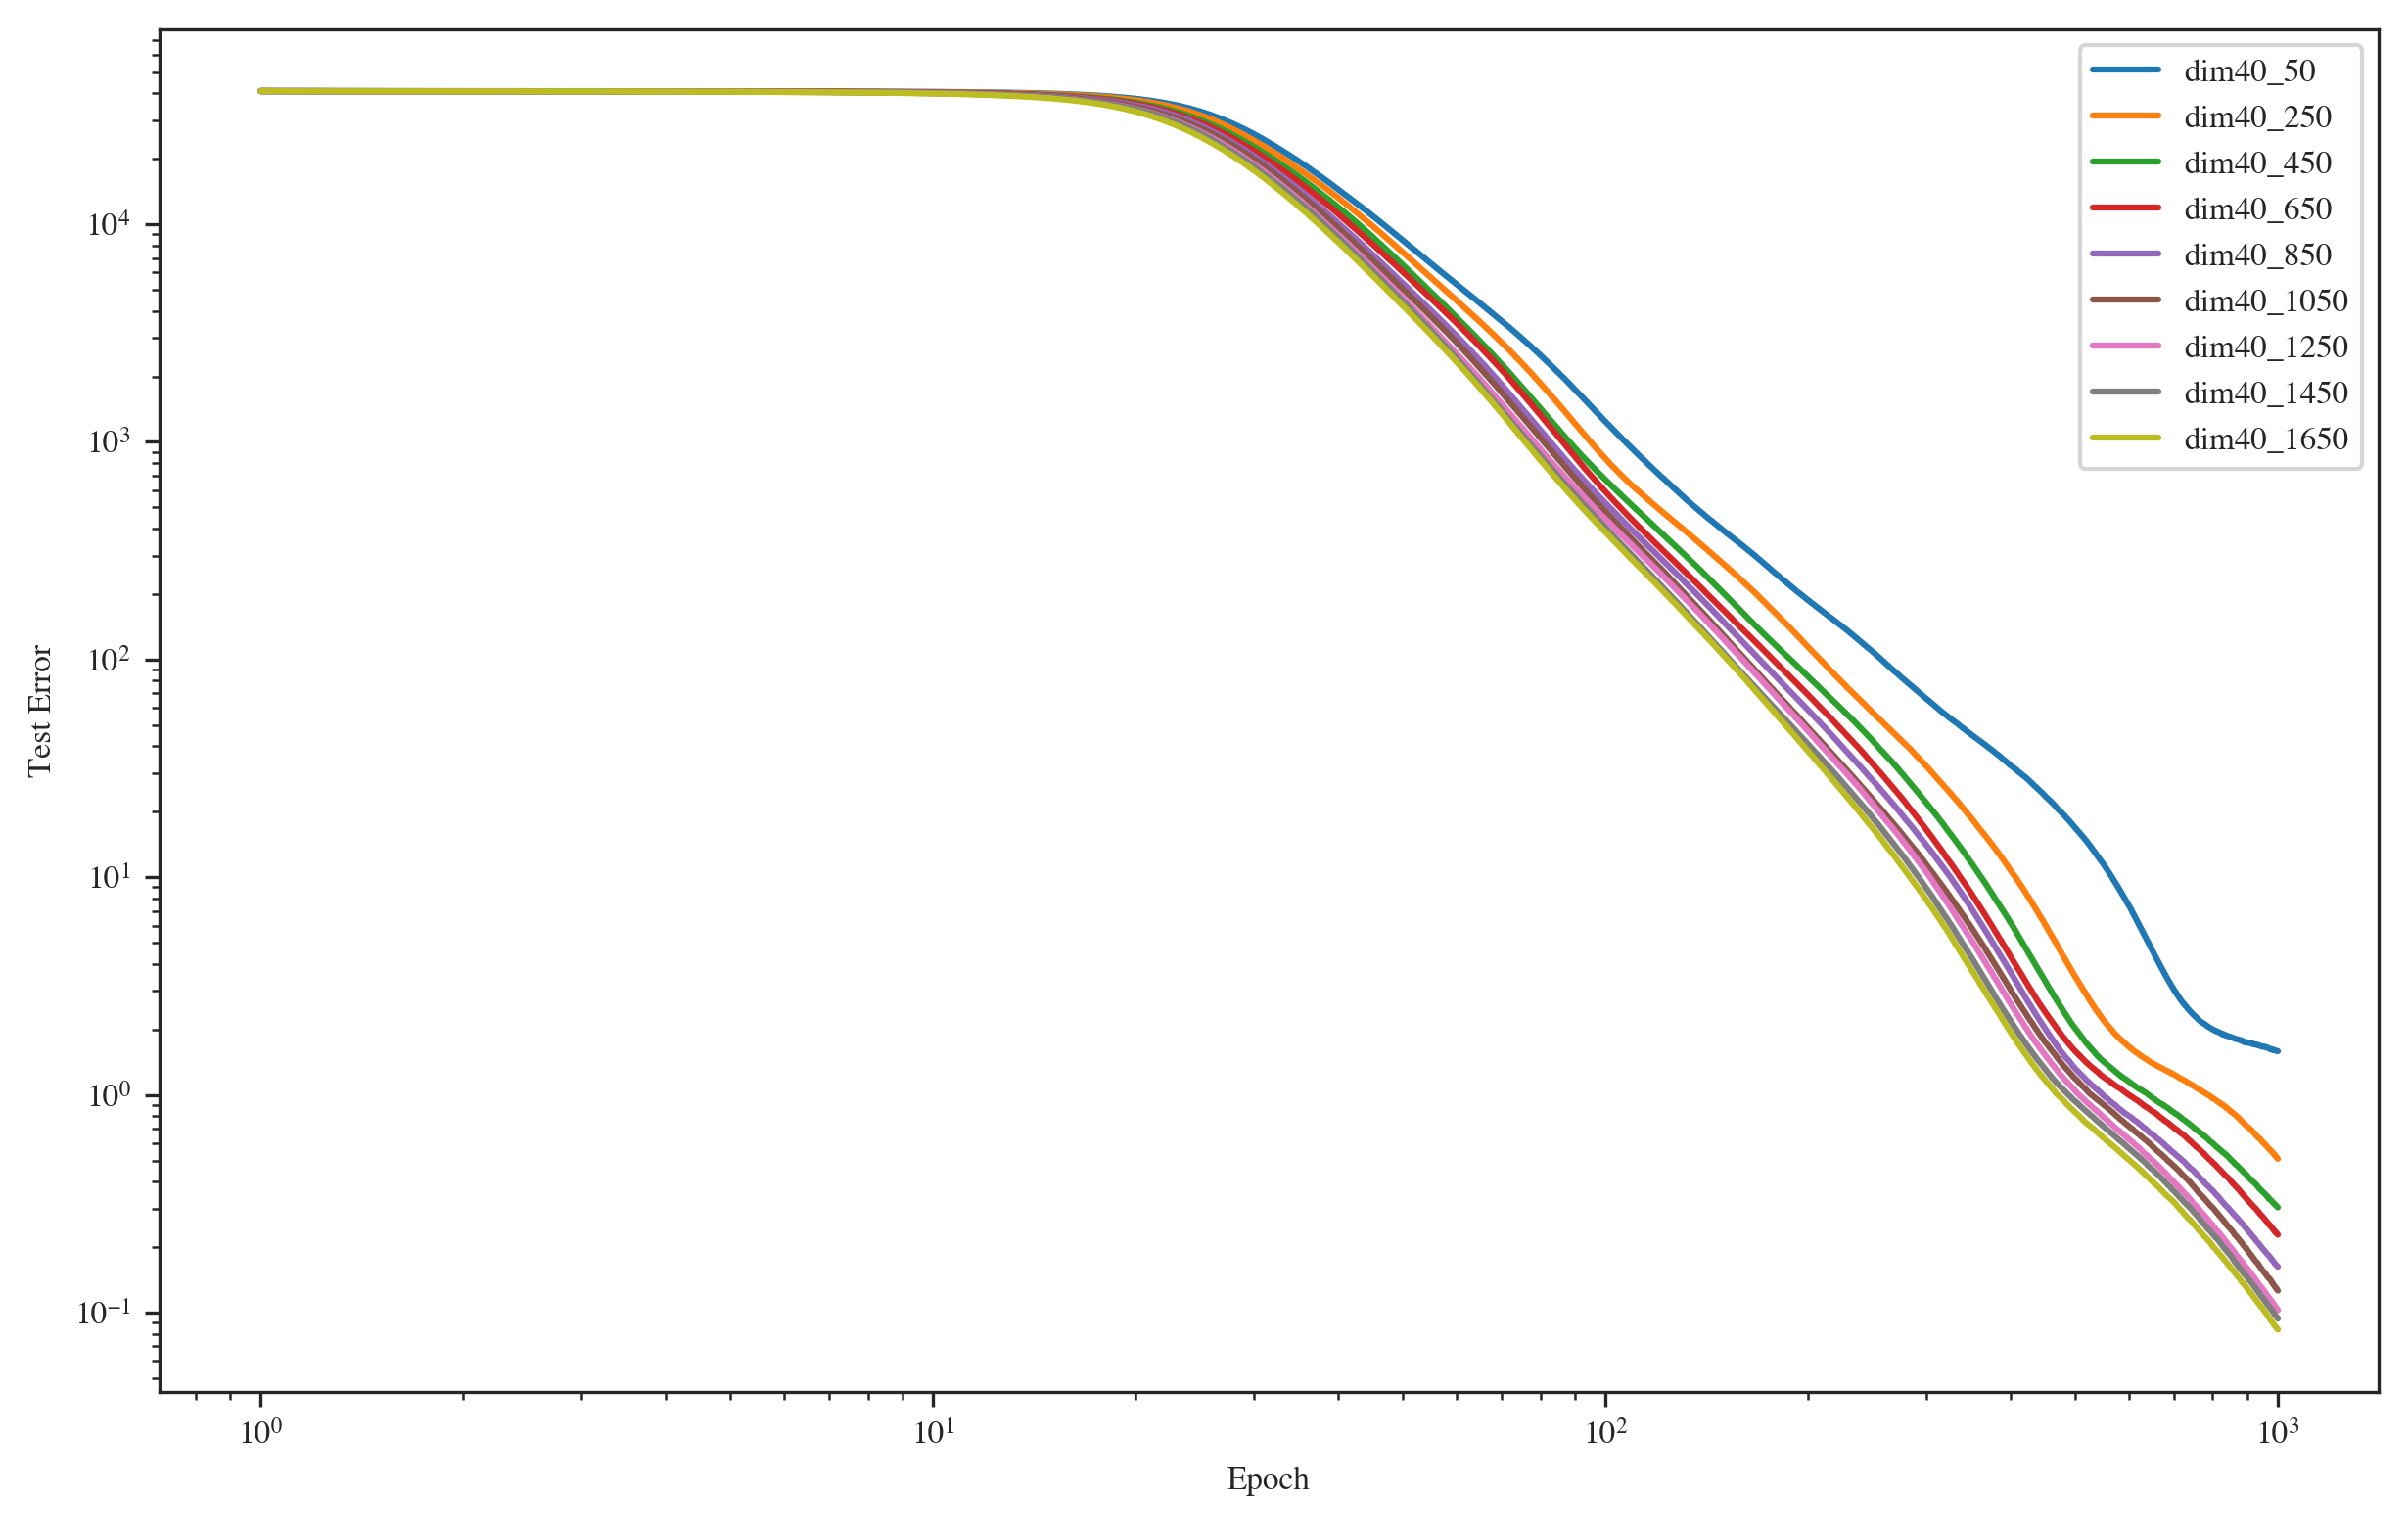

In [103]:
plt.figure(figsize = (some_multiplier_1 * WIDTH, some_multiplier_2 * HEIGHT))
plt.plot(epoch, model_losses[0])
plt.plot(epoch, model_losses[1])
plt.plot(epoch, model_losses[2])
plt.plot(epoch, model_losses[3])
plt.plot(epoch, model_losses[4])
plt.plot(epoch, model_losses[5])
plt.plot(epoch, model_losses[6])
plt.plot(epoch, model_losses[7])
plt.plot(epoch, model_losses[8])
#plt.plot(epoch, model_losses[9])
plt.xscale('log')
plt.yscale('log')

plt.ylabel('Test Error')
plt.xlabel('Epoch')
plt.legend(labels = model_fig, loc="upper right")
seaborn.set_style("ticks")
plt.rcParams["font.family"] = "Times"
plt.rcParams['figure.dpi'] = 300
plt.rc('xtick', labelsize=8)
plt.rc('ytick', labelsize=8)
plt.rc('axes', labelsize=8)
plt.rc('legend', fontsize=8)
plt.rc('axes', titlesize=10)

#plt.savefig("ten_percent_losses.pdf")
plt.show()

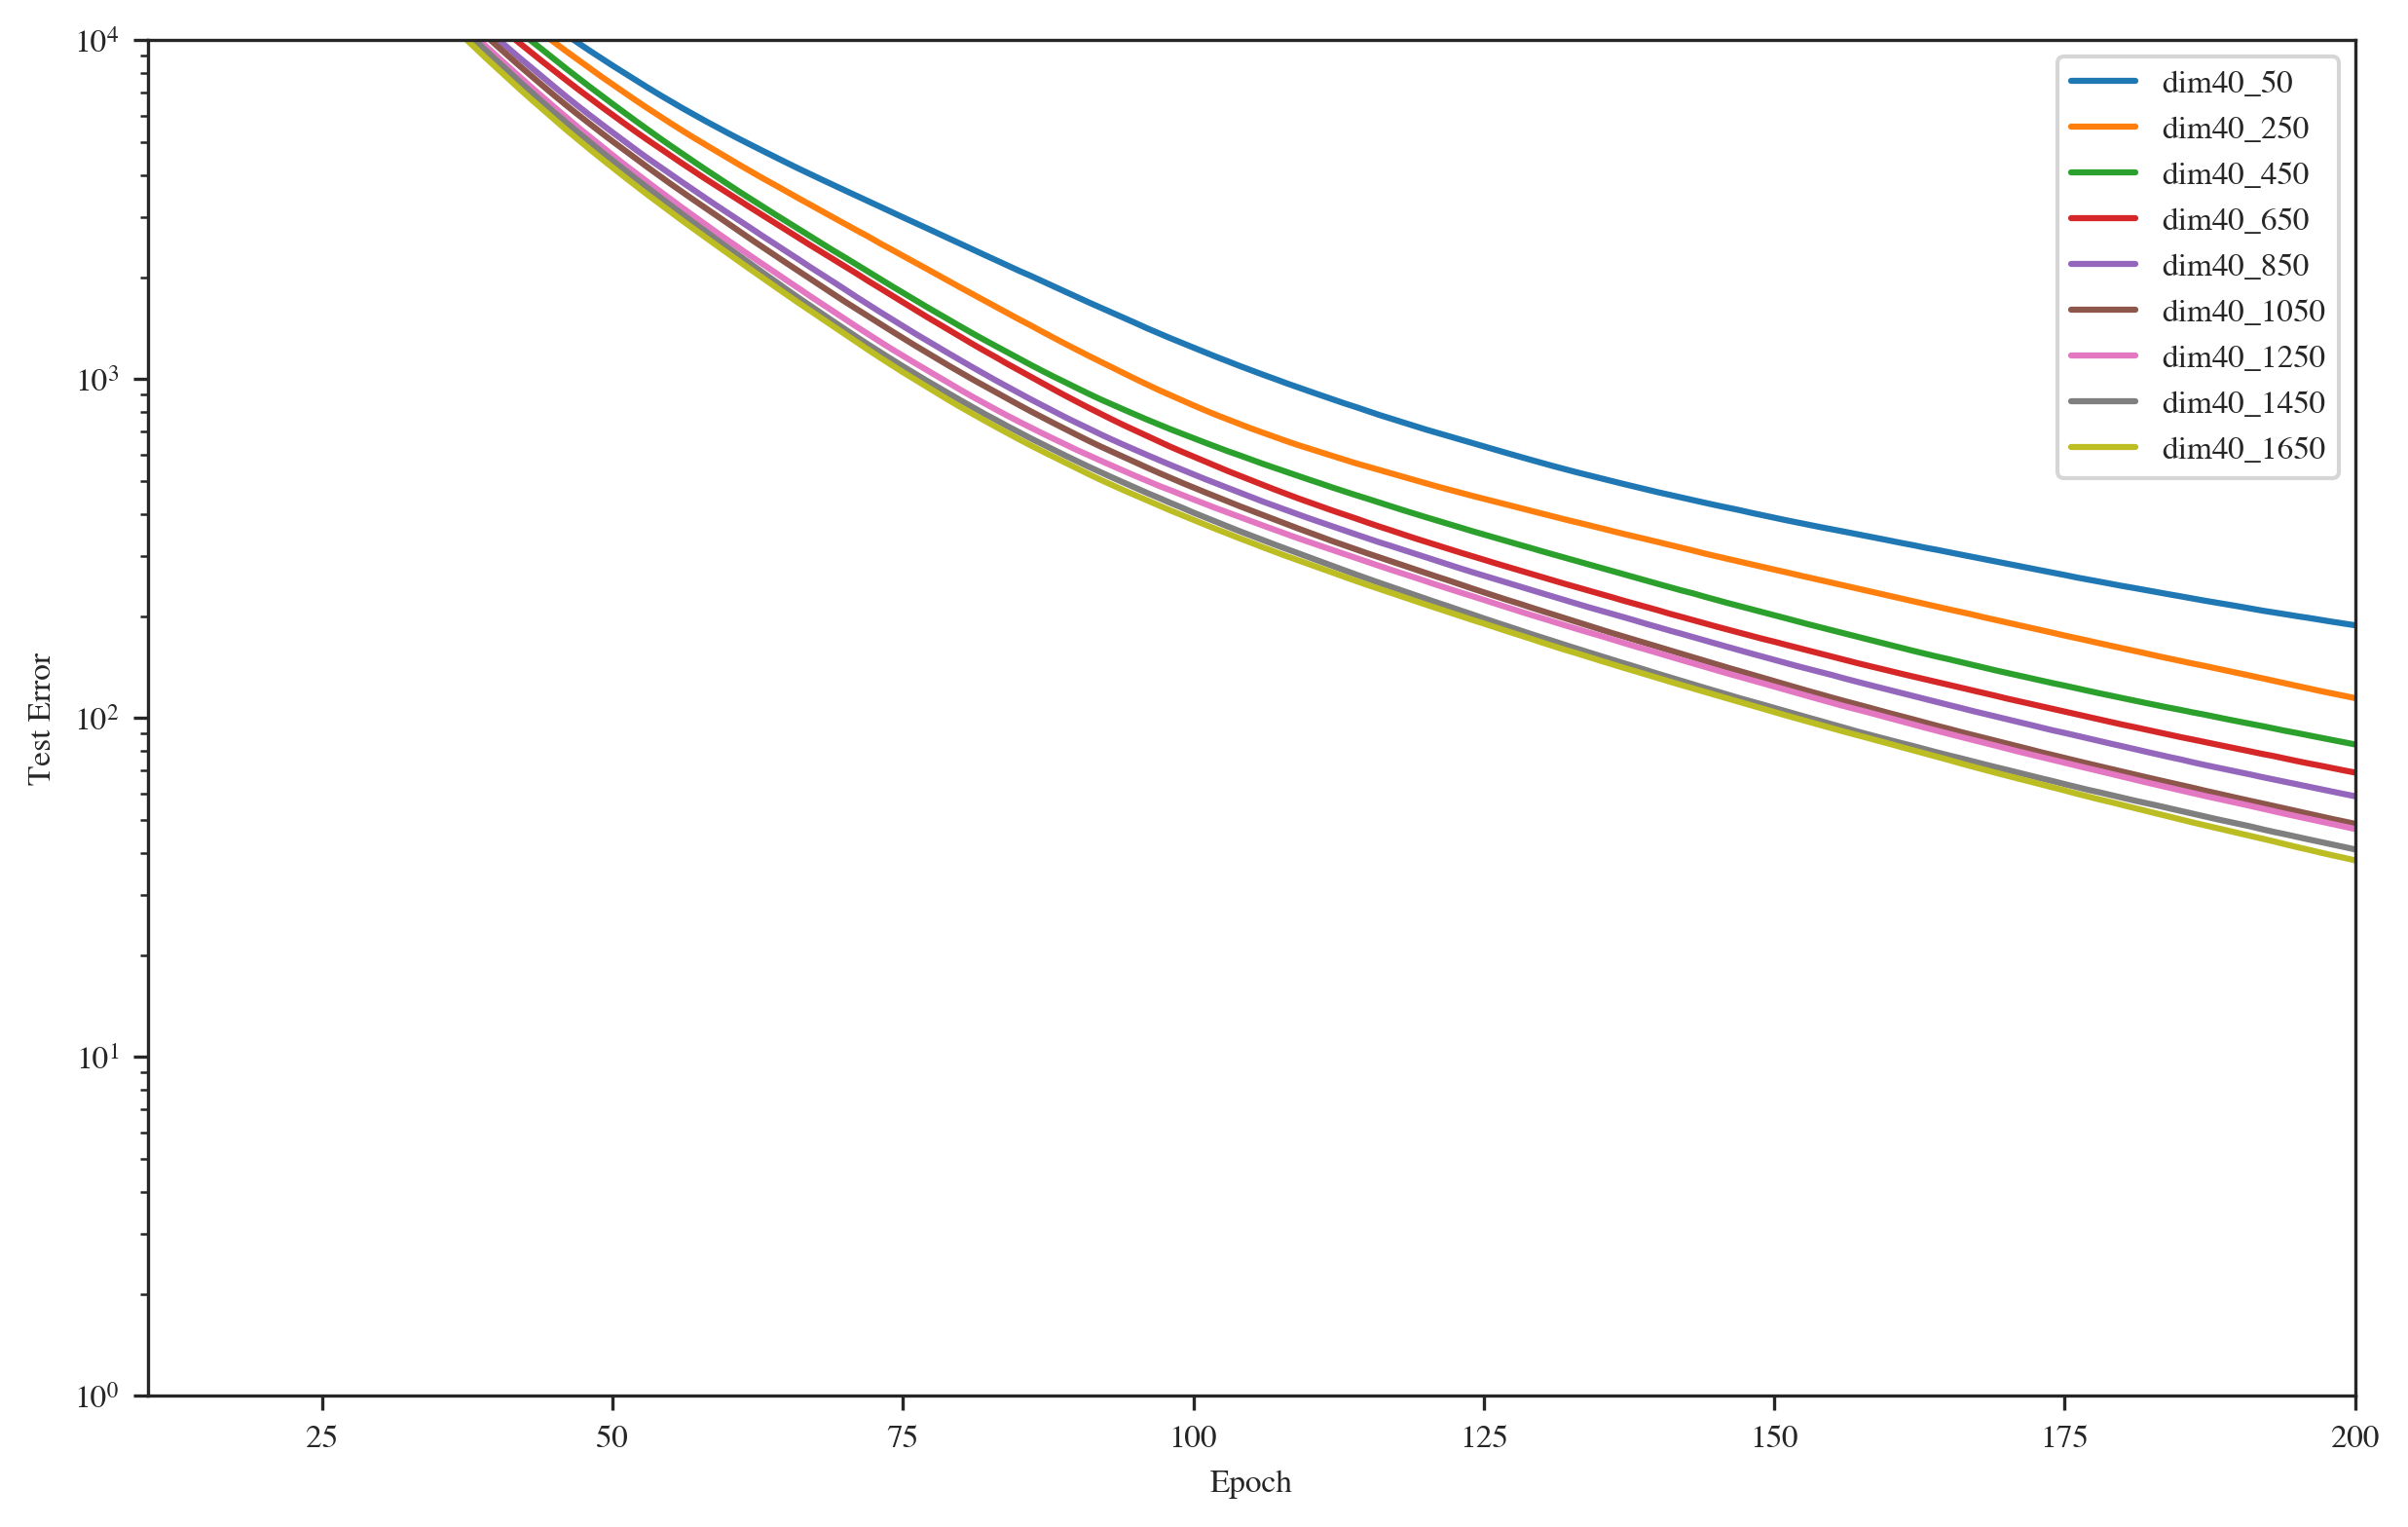

In [113]:
plt.figure(figsize = (some_multiplier_1 * WIDTH, some_multiplier_2 * HEIGHT))
plt.plot(epoch, model_losses[0])
plt.plot(epoch, model_losses[1])
plt.plot(epoch, model_losses[2])
plt.plot(epoch, model_losses[3])
plt.plot(epoch, model_losses[4])
plt.plot(epoch, model_losses[5])
plt.plot(epoch, model_losses[6])
plt.plot(epoch, model_losses[7])
plt.plot(epoch, model_losses[8])
#plt.plot(epoch, model_losses[9])
#plt.xscale('log')
plt.yscale('log')

plt.ylabel('Test Error')
plt.xlabel('Epoch')
plt.legend(labels = model_fig, loc="upper right")
seaborn.set_style("ticks")
plt.rcParams["font.family"] = "Times"
plt.rcParams['figure.dpi'] = 300
plt.rc('xtick', labelsize=8)
plt.rc('ytick', labelsize=8)
plt.rc('axes', labelsize=8)
plt.rc('legend', fontsize=8)
plt.rc('axes', titlesize=10)
plt.xlim([10, 200])
plt.ylim([1,10**4])
#plt.savefig("ten_percent_losses.pdf")
plt.show()

In [115]:
model_ref = ['dim80_1 - loss/test', 'dim80_2 - loss/test', 'dim80_3 - loss/test', 'dim80_4 - loss/test', 'dim80_5 - loss/test', 'dim80_6 - loss/test', 'dim80_7 - loss/test', 'dim80_8 - loss/test', 'dim80_9 - loss/test', 'dim80_10 - loss/test']
model_fig = ['dim80_50', 'dim80_250', 'dim80_450', 'dim80_650', 'dim80_850', 'dim80_1050', 'dim80_1250', 'dim80_1450', 'dim80_1650', 'dim80_1850']

model_losses = []
for i in model_ref:
    model_loss = dim80_metrics[i].values
    model_losses.append(model_loss.transpose())

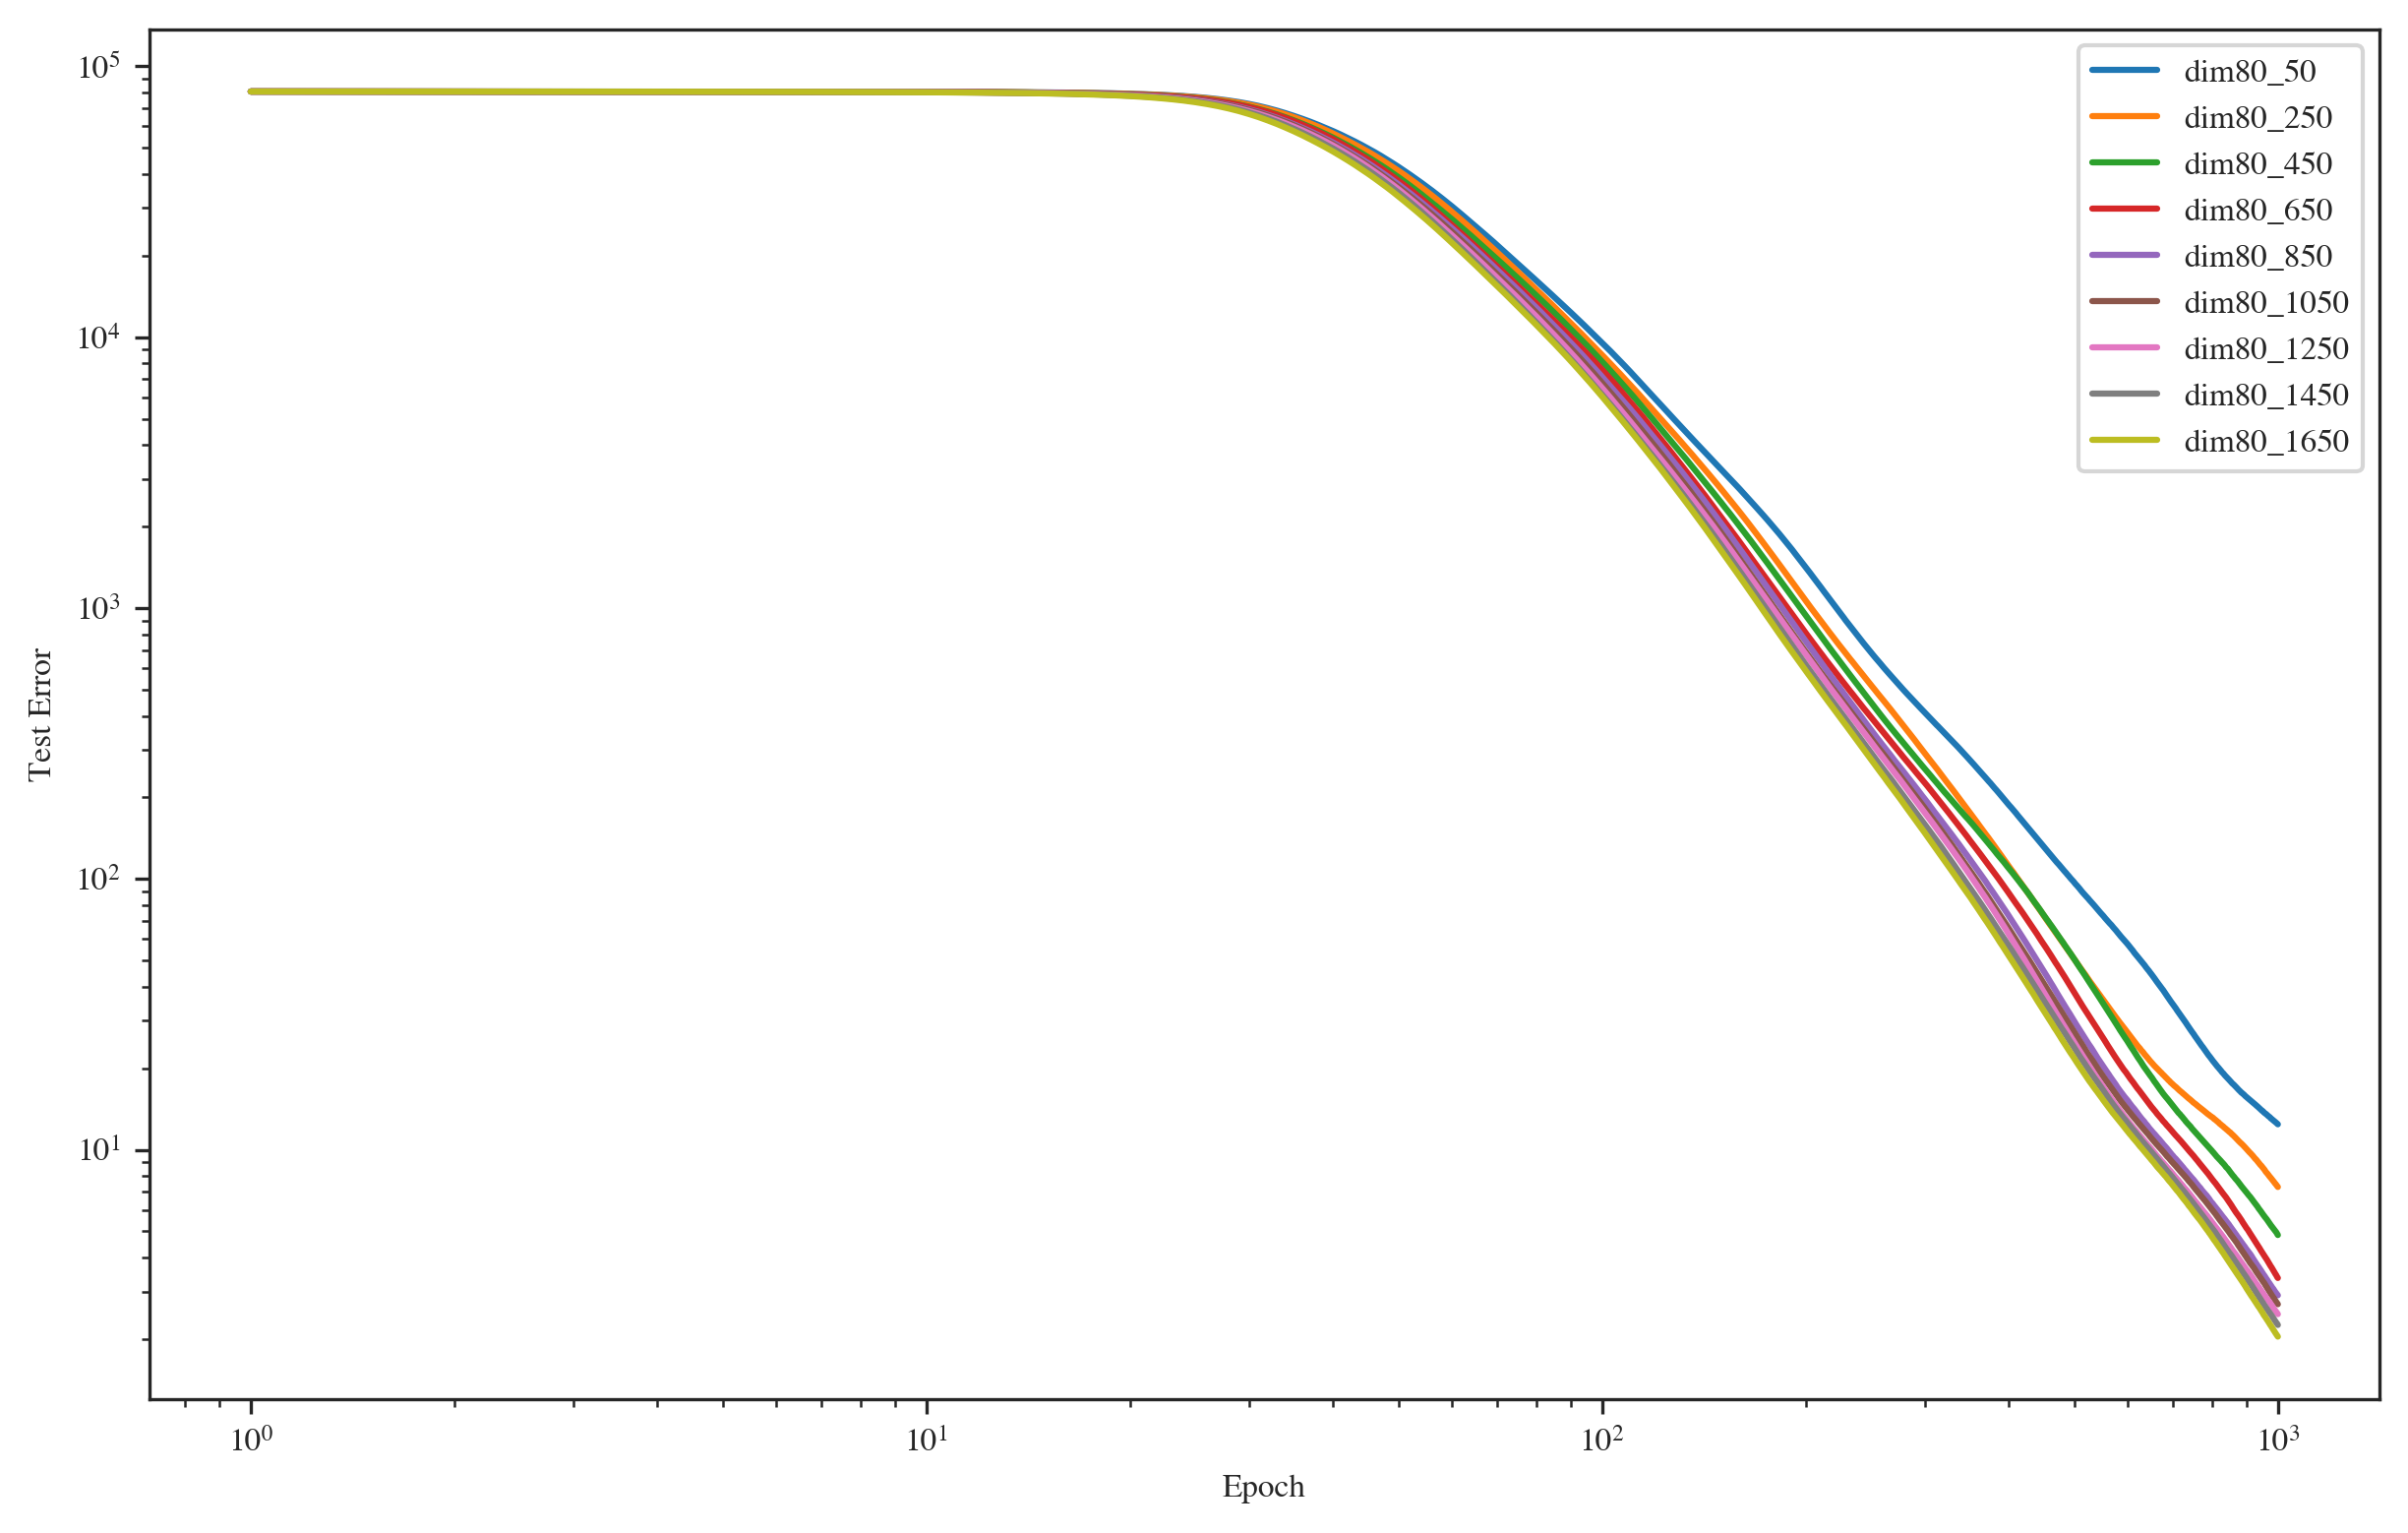

In [116]:
plt.figure(figsize = (some_multiplier_1 * WIDTH, some_multiplier_2 * HEIGHT))
plt.plot(epoch, model_losses[0])
plt.plot(epoch, model_losses[1])
plt.plot(epoch, model_losses[2])
plt.plot(epoch, model_losses[3])
plt.plot(epoch, model_losses[4])
plt.plot(epoch, model_losses[5])
plt.plot(epoch, model_losses[6])
plt.plot(epoch, model_losses[7])
plt.plot(epoch, model_losses[8])
#plt.plot(epoch, model_losses[9])
plt.xscale('log')
plt.yscale('log')

plt.ylabel('Test Error')
plt.xlabel('Epoch')
plt.legend(labels = model_fig, loc="upper right")
seaborn.set_style("ticks")
plt.rcParams["font.family"] = "Times"
plt.rcParams['figure.dpi'] = 300
plt.rc('xtick', labelsize=8)
plt.rc('ytick', labelsize=8)
plt.rc('axes', labelsize=8)
plt.rc('legend', fontsize=8)
plt.rc('axes', titlesize=10)

#plt.savefig("ten_percent_losses.pdf")
plt.show()

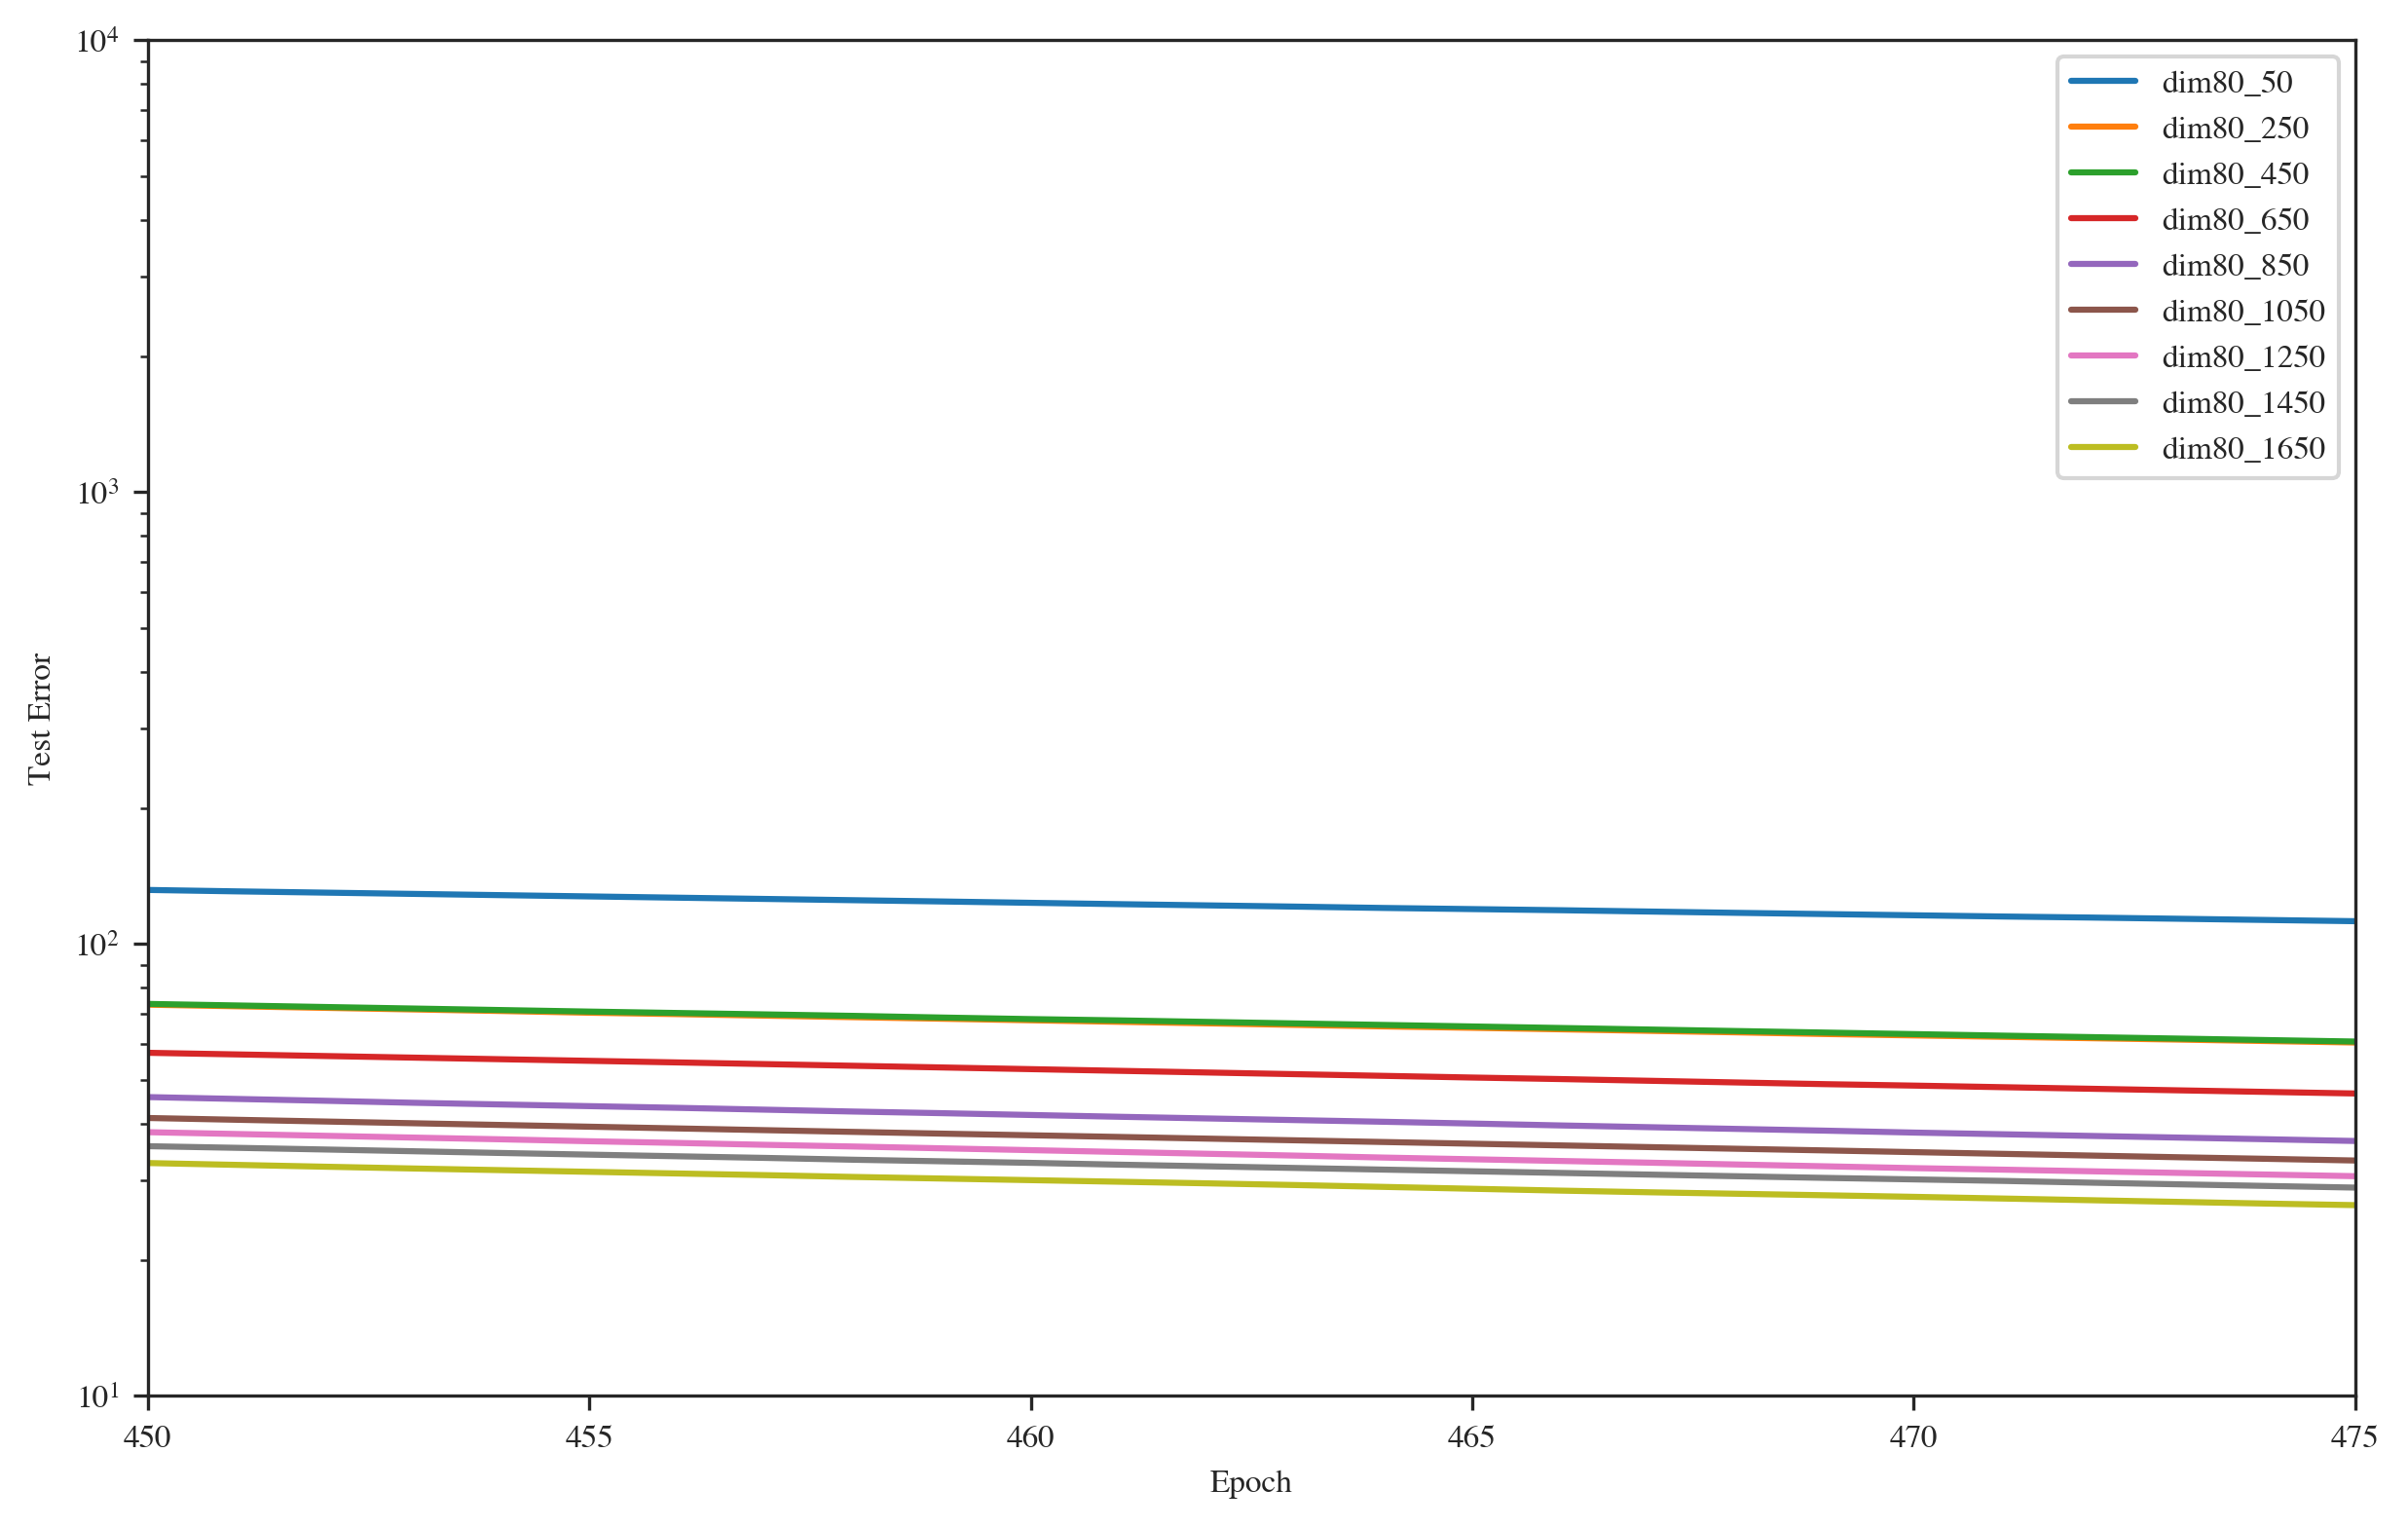

In [119]:
plt.figure(figsize = (some_multiplier_1 * WIDTH, some_multiplier_2 * HEIGHT))
plt.plot(epoch, model_losses[0])
plt.plot(epoch, model_losses[1])
plt.plot(epoch, model_losses[2])
plt.plot(epoch, model_losses[3])
plt.plot(epoch, model_losses[4])
plt.plot(epoch, model_losses[5])
plt.plot(epoch, model_losses[6])
plt.plot(epoch, model_losses[7])
plt.plot(epoch, model_losses[8])
#plt.plot(epoch, model_losses[9])
#plt.xscale('log')
plt.yscale('log')

plt.ylabel('Test Error')
plt.xlabel('Epoch')
plt.legend(labels = model_fig, loc="upper right")
seaborn.set_style("ticks")
plt.rcParams["font.family"] = "Times"
plt.rcParams['figure.dpi'] = 300
plt.rc('xtick', labelsize=8)
plt.rc('ytick', labelsize=8)
plt.rc('axes', labelsize=8)
plt.rc('legend', fontsize=8)
plt.rc('axes', titlesize=10)
plt.xlim([450, 475])
plt.ylim([10,10**4])
#plt.savefig("ten_percent_losses.pdf")
plt.show()

In [120]:
model_ref = ['dim120_1 - loss/test', 'dim120_2 - loss/test', 'dim120_3 - loss/test', 'dim120_4 - loss/test', 'dim120_5 - loss/test', 'dim120_6 - loss/test', 'dim120_7 - loss/test', 'dim120_8 - loss/test', 'dim120_9 - loss/test', 'dim120_10 - loss/test']
model_fig = ['dim120_50', 'dim120_250', 'dim120_450', 'dim120_650', 'dim120_850', 'dim120_1050', 'dim120_1250', 'dim120_1450', 'dim120_1650', 'dim120_1850']

model_losses = []
for i in model_ref:
    model_loss = dim120_metrics[i].values
    model_losses.append(model_loss.transpose())

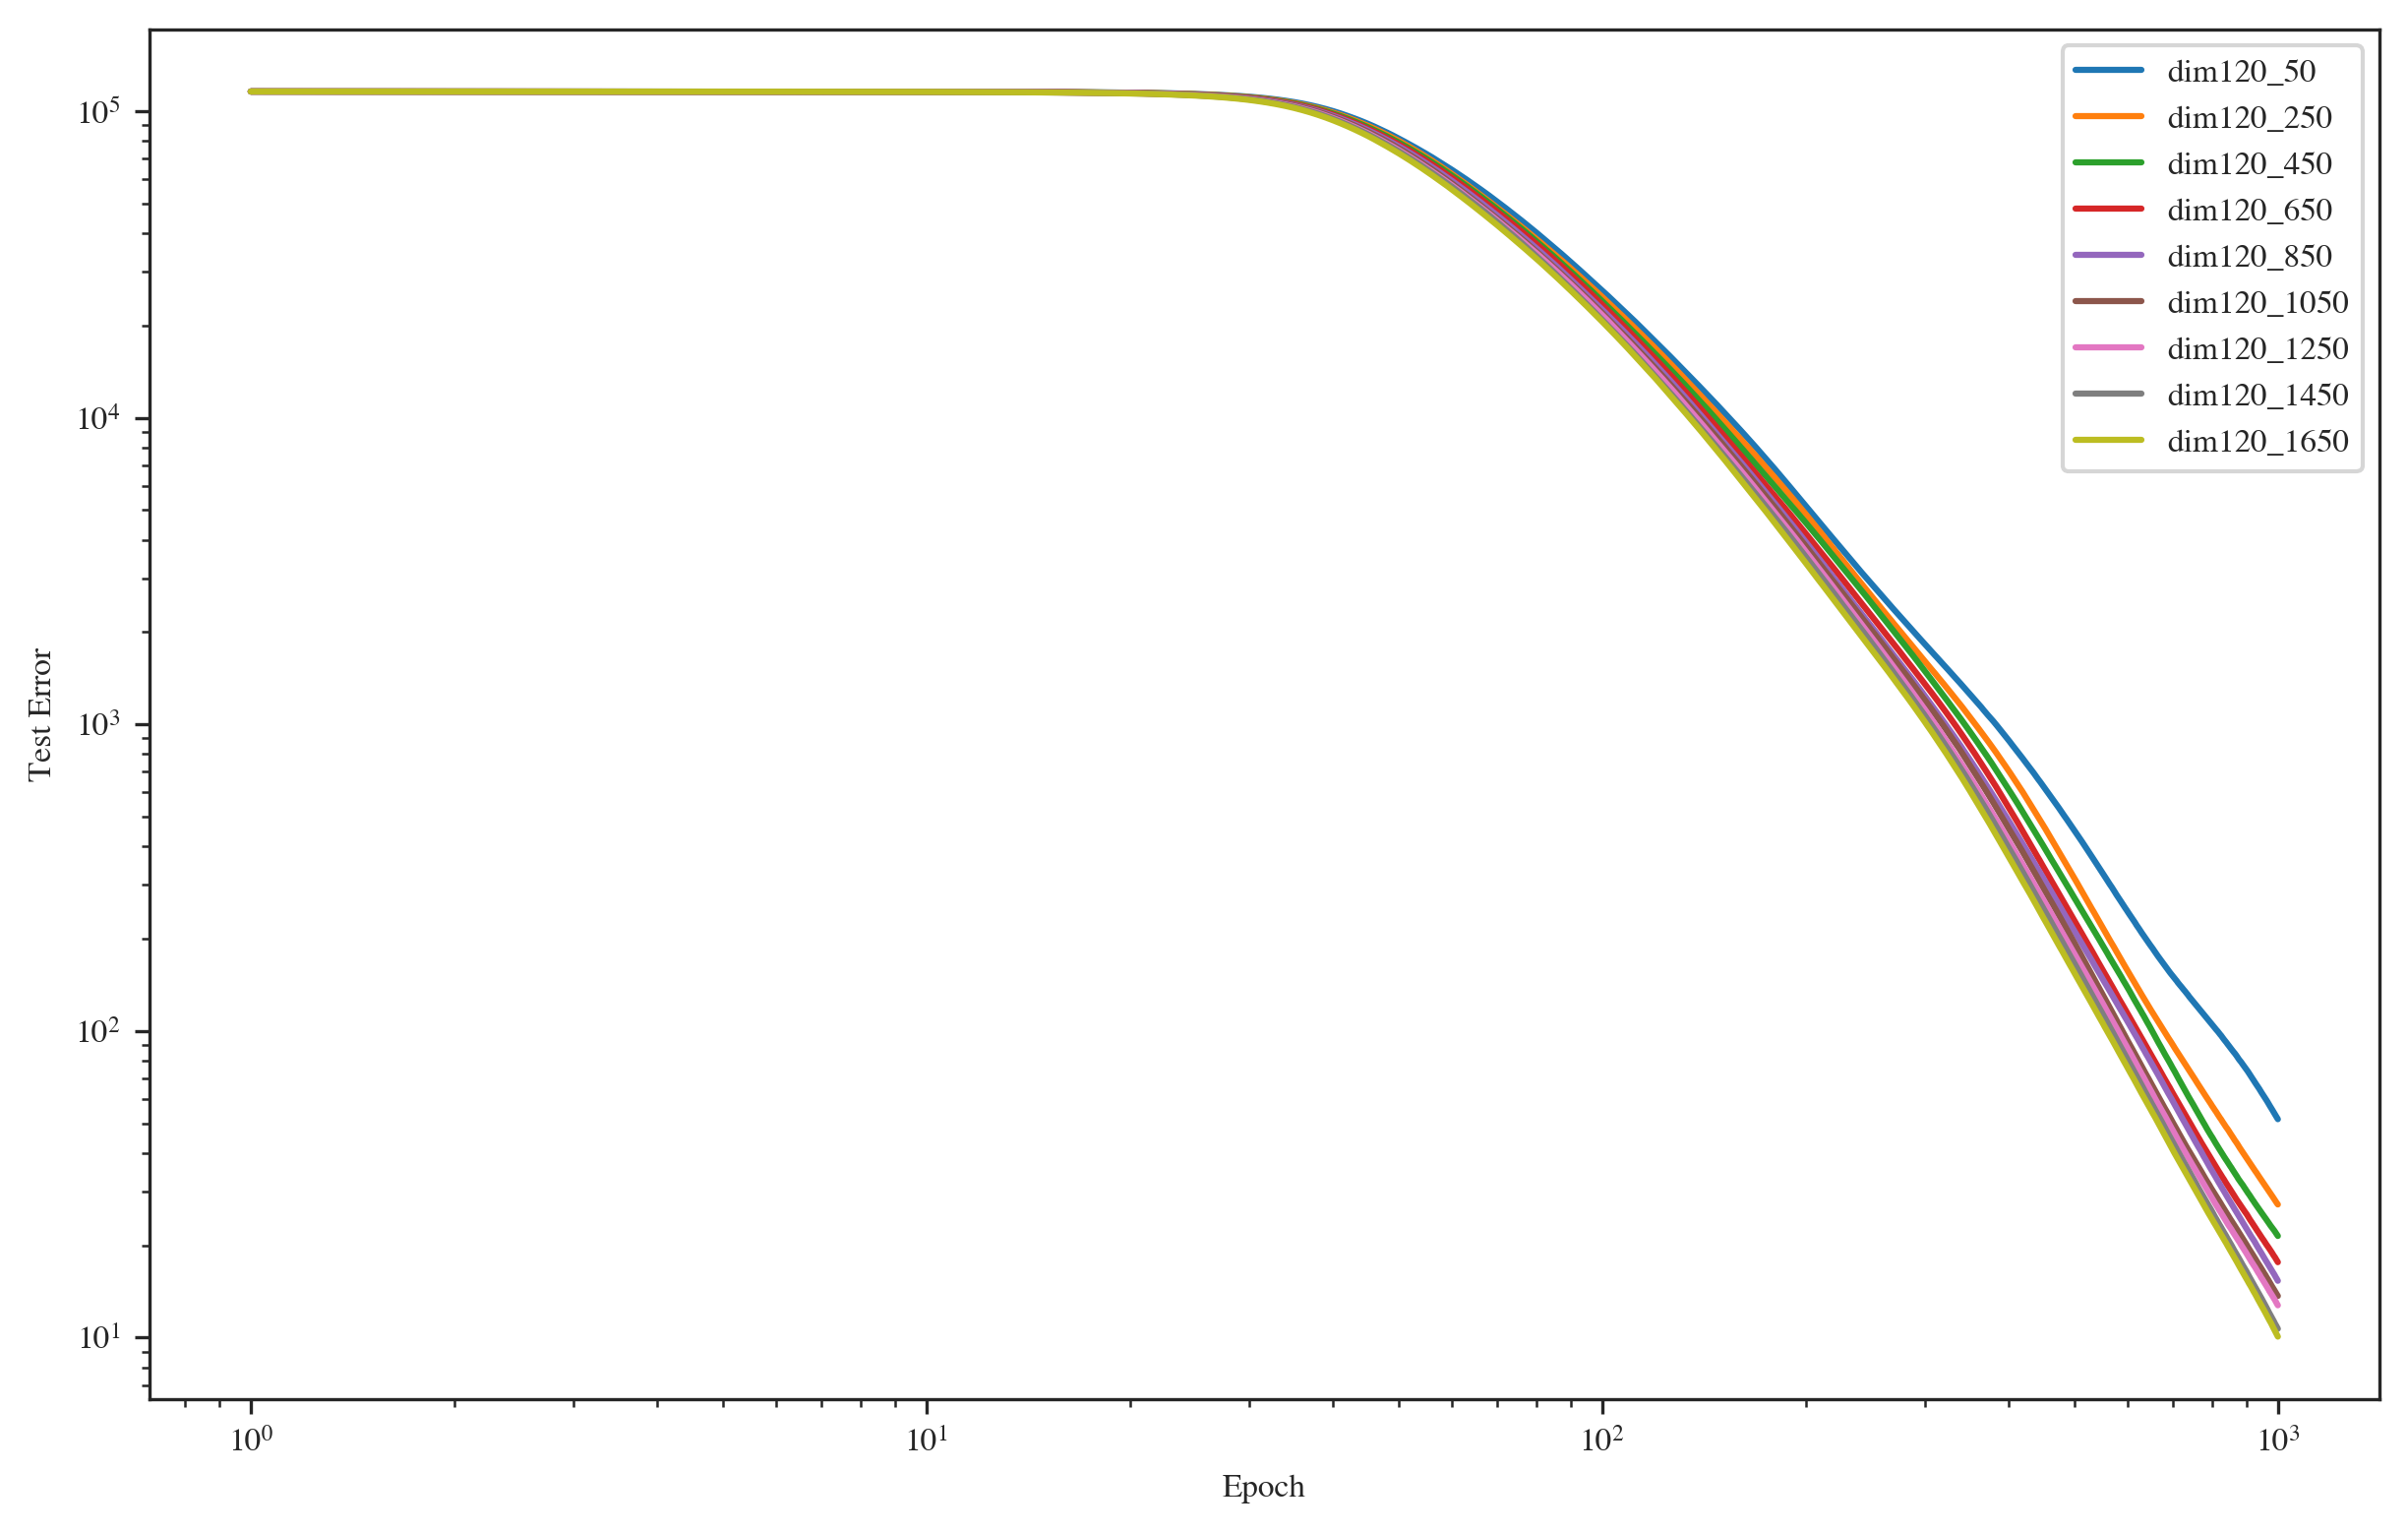

In [121]:
plt.figure(figsize = (some_multiplier_1 * WIDTH, some_multiplier_2 * HEIGHT))
plt.plot(epoch, model_losses[0])
plt.plot(epoch, model_losses[1])
plt.plot(epoch, model_losses[2])
plt.plot(epoch, model_losses[3])
plt.plot(epoch, model_losses[4])
plt.plot(epoch, model_losses[5])
plt.plot(epoch, model_losses[6])
plt.plot(epoch, model_losses[7])
plt.plot(epoch, model_losses[8])
#plt.plot(epoch, model_losses[9])
plt.xscale('log')
plt.yscale('log')

plt.ylabel('Test Error')
plt.xlabel('Epoch')
plt.legend(labels = model_fig, loc="upper right")
seaborn.set_style("ticks")
plt.rcParams["font.family"] = "Times"
plt.rcParams['figure.dpi'] = 300
plt.rc('xtick', labelsize=8)
plt.rc('ytick', labelsize=8)
plt.rc('axes', labelsize=8)
plt.rc('legend', fontsize=8)
plt.rc('axes', titlesize=10)

#plt.savefig("ten_percent_losses.pdf")
plt.show()

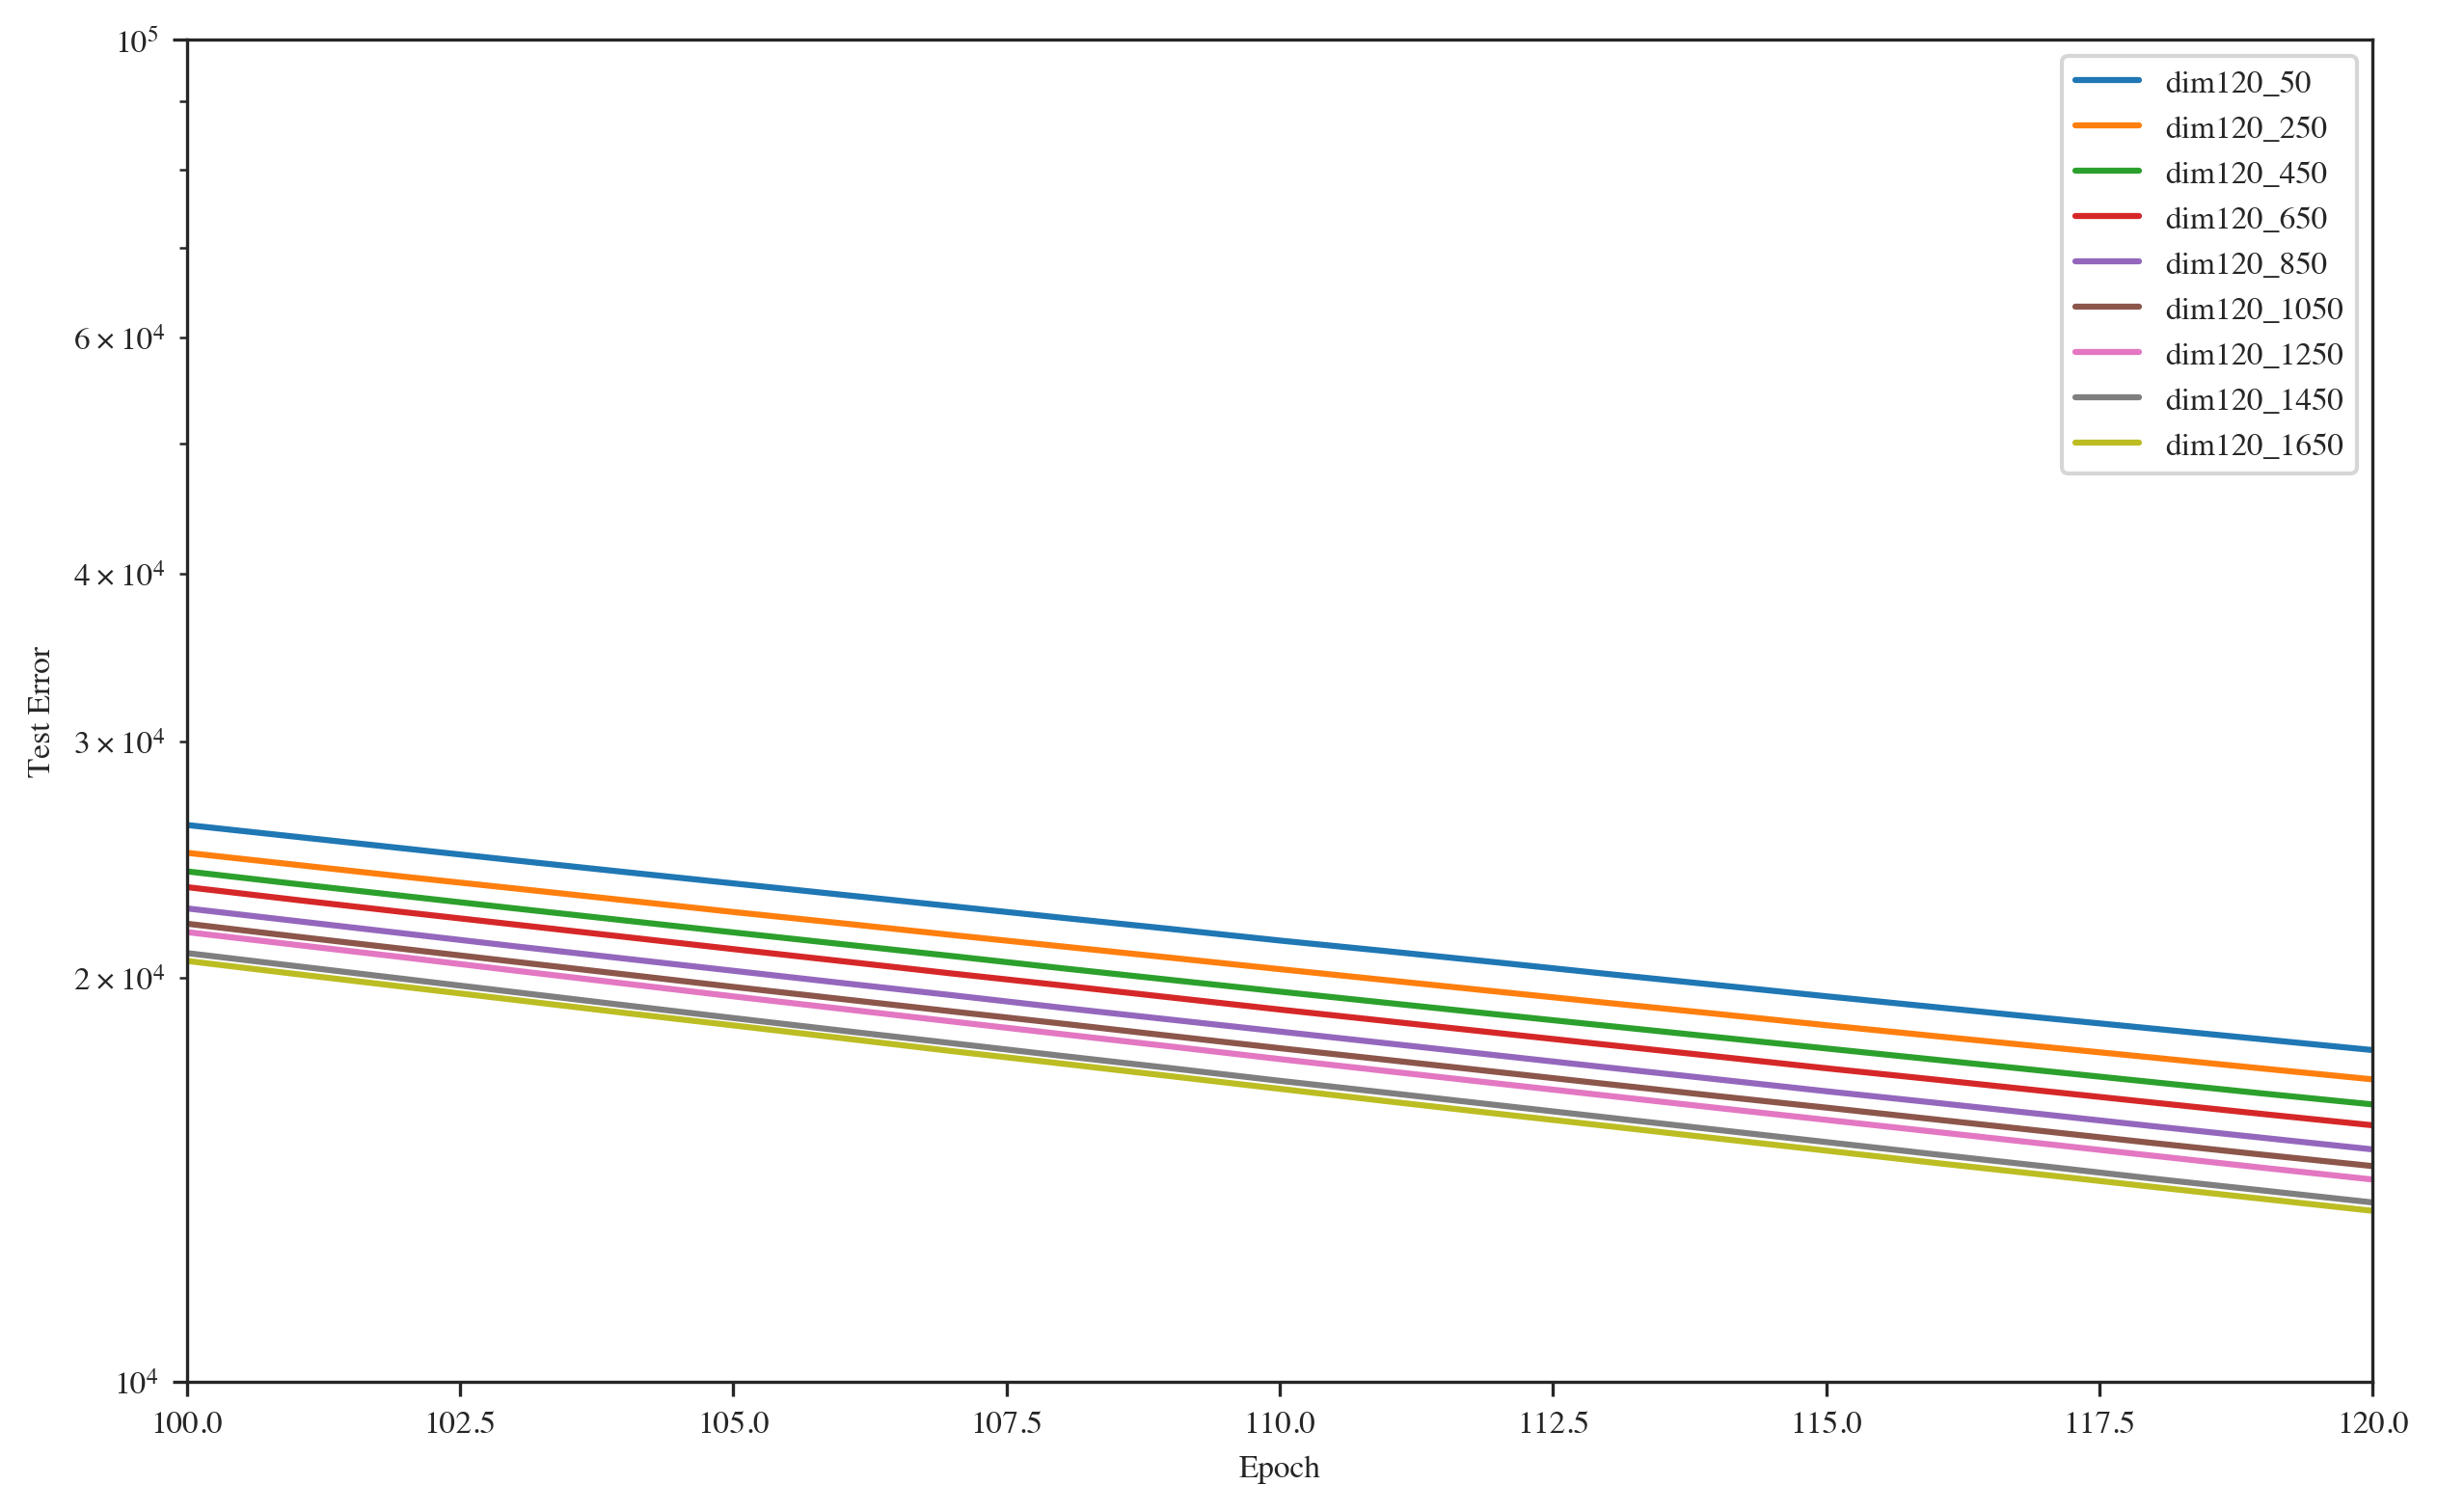

In [130]:
plt.figure(figsize = (some_multiplier_1 * WIDTH, some_multiplier_2 * HEIGHT))
plt.plot(epoch, model_losses[0])
plt.plot(epoch, model_losses[1])
plt.plot(epoch, model_losses[2])
plt.plot(epoch, model_losses[3])
plt.plot(epoch, model_losses[4])
plt.plot(epoch, model_losses[5])
plt.plot(epoch, model_losses[6])
plt.plot(epoch, model_losses[7])
plt.plot(epoch, model_losses[8])
#plt.plot(epoch, model_losses[9])
#plt.xscale('log')
plt.yscale('log')

plt.ylabel('Test Error')
plt.xlabel('Epoch')
plt.legend(labels = model_fig, loc="upper right")
seaborn.set_style("ticks")
plt.rcParams["font.family"] = "Times"
plt.rcParams['figure.dpi'] = 300
plt.rc('xtick', labelsize=8)
plt.rc('ytick', labelsize=8)
plt.rc('axes', labelsize=8)
plt.rc('legend', fontsize=8)
plt.rc('axes', titlesize=10)
plt.xlim([100, 120])
plt.ylim([10000,10**5])
#plt.savefig("ten_percent_losses.pdf")
plt.show()

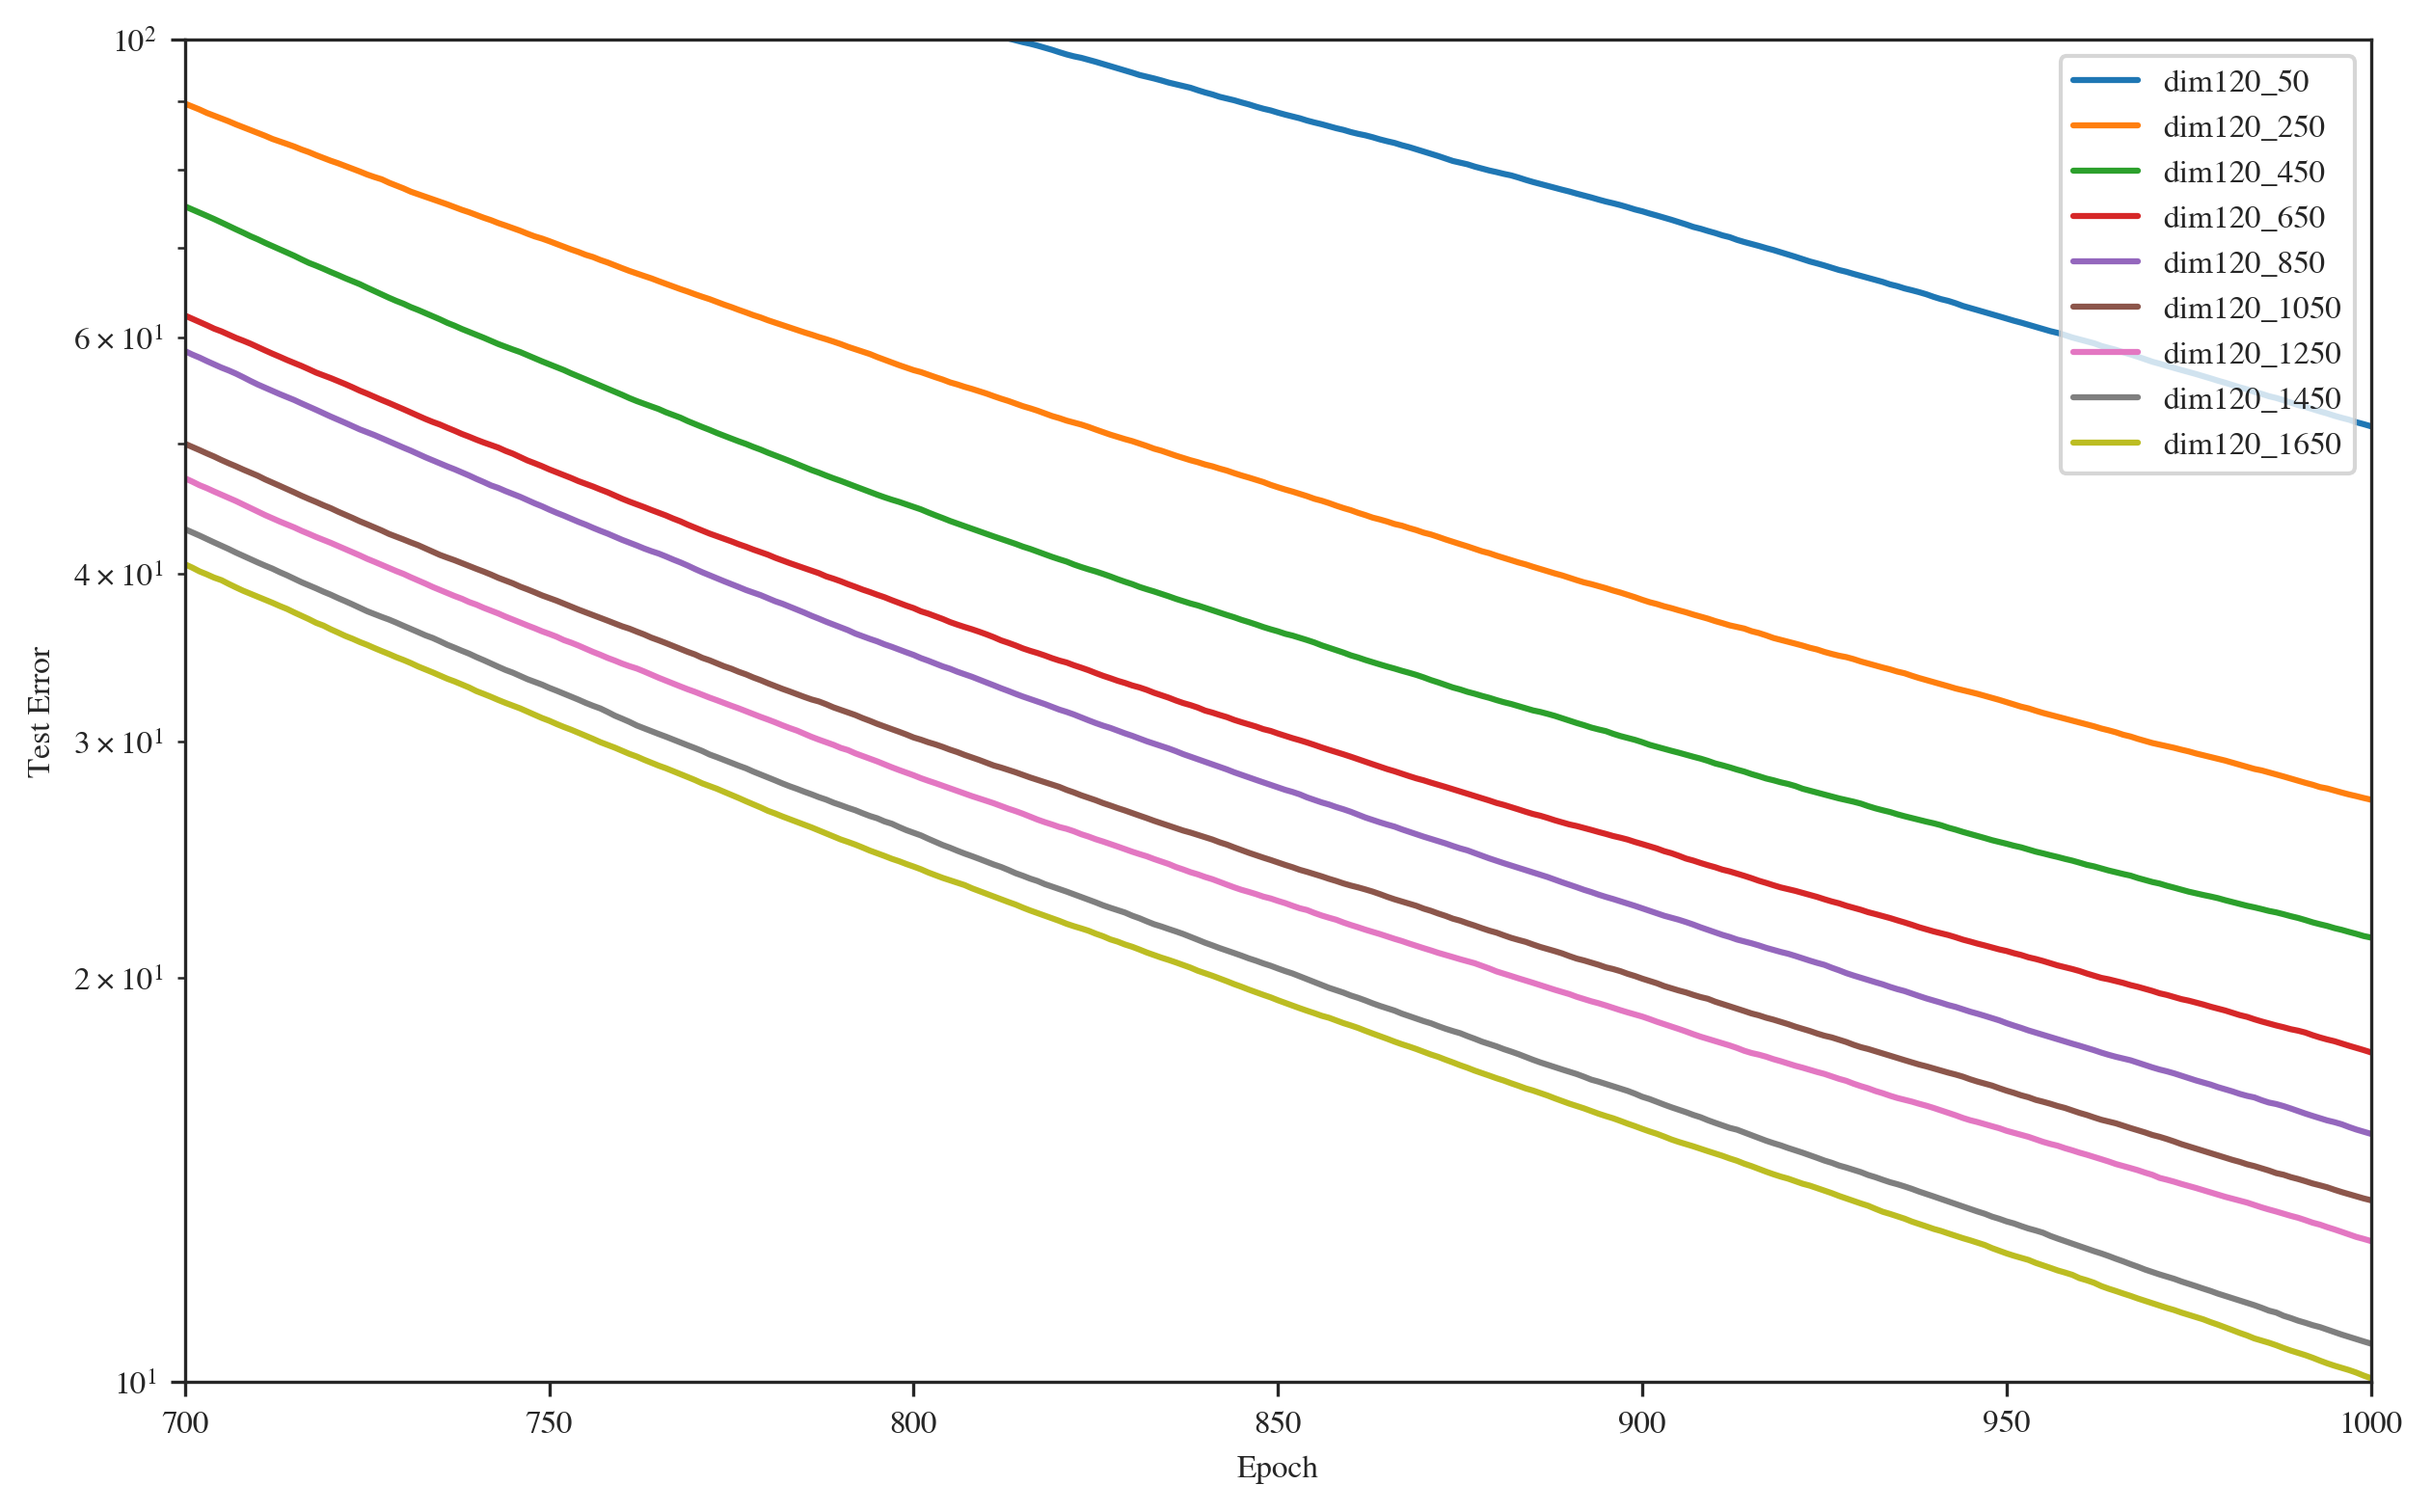

In [132]:
plt.figure(figsize = (some_multiplier_1 * WIDTH, some_multiplier_2 * HEIGHT))
plt.plot(epoch, model_losses[0])
plt.plot(epoch, model_losses[1])
plt.plot(epoch, model_losses[2])
plt.plot(epoch, model_losses[3])
plt.plot(epoch, model_losses[4])
plt.plot(epoch, model_losses[5])
plt.plot(epoch, model_losses[6])
plt.plot(epoch, model_losses[7])
plt.plot(epoch, model_losses[8])
#plt.plot(epoch, model_losses[9])
#plt.xscale('log')
plt.yscale('log')

plt.ylabel('Test Error')
plt.xlabel('Epoch')
plt.legend(labels = model_fig, loc="upper right")
seaborn.set_style("ticks")
plt.rcParams["font.family"] = "Times"
plt.rcParams['figure.dpi'] = 300
plt.rc('xtick', labelsize=8)
plt.rc('ytick', labelsize=8)
plt.rc('axes', labelsize=8)
plt.rc('legend', fontsize=8)
plt.rc('axes', titlesize=10)
plt.xlim([700, 1000])
plt.ylim([10,100])
#plt.savefig("ten_percent_losses.pdf")
plt.show()